<a href="https://colab.research.google.com/github/jmontano1987/pdg/blob/main/Proyecto_de_Grado_version_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Proyecto de Grado**

**Título:** Modelo para la detección de Noticias Falsas en tweets con formato de texto en el contexto político colombiano para las elecciones del año 2022.

**Integrantes:**
* Jesus Eduardo Flores Q.
* Juan Gabriel Montaño M.

#**Instalaciones**

In [ ]:
!pip install tweepy
!pip3 install tqdm
!pip install spacy
!pip install matplotlib
!pip install wordcloud
!pip install unidecode
!pip install scikit-plot
!pip install bayesian-optimization
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
!pip install stop-words

# paquetes necesarios para trabajar con BERT
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

#**Librerias**

In [ ]:
import io
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
import string
import tweepy
from tqdm.notebook import tqdm as tqdm_notebook
from dateutil import tz
from datetime import datetime 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import unidecode
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import requests
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import random
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
from google.colab import (
    drive,
    files
)
from tqdm import tqdm
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from stop_words import get_stop_words
import pickle
import xgboost as xgb
from sklearn.linear_model import PassiveAggressiveClassifier
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

#### 
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

## libreria para descargar un .zip desde una url de descarga
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import os


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#**Funciones**

In [ ]:
np.random.seed(42)
rng = np.random.RandomState(1)

In [ ]:
# al llamar la función y pasarle una URL, descarga el arhcivo que debe estar en formato .zip y lo descomprime en la ruta content de colab
def download_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

In [ ]:
#Funcion que convierte el formato de la fecha del tweet en hora GMT -5 Colombia
def convert_date(str_date):
  str_format_date = '%Y-%m-%d %H:%M:%S' 
  from_zone = tz.gettz('UTC')
  to_zone = tz.gettz('America/Bogota')
  date_convert = datetime.strptime(str(str_date), str_format_date)
  date_convert = date_convert.replace(tzinfo=from_zone)
  date_convert = date_convert.astimezone(to_zone)
  date_convert = datetime.strftime(date_convert,'%d/%m/%Y %H:%M:%S')
  return date_convert

In [ ]:
#Funcion para obtener los tweets de un usuario especifio de twitter - Se quitan los RT
def get_tweets(api,username,items,rts):
  tweets={}
  for tweet in tqdm_notebook(tweepy.Cursor(api.user_timeline, screen_name = username, tweet_mode='extended',include_rts=rts).items(items)):
      tweets[tweet.id]= {
          'full_text': tweet.full_text,
          'created_at': convert_date(tweet.created_at),
          'author_name': tweet.user.name,
          'author_handler': str(tweet.user.screen_name),
          'user_description': tweet.user.description,
          'user_location': tweet.user.location,
          'user_followers_count': tweet.user.followers_count,
          'user_created_at': convert_date(tweet.user.created_at),
          'user_following_count': tweet.user.friends_count,
          'user_verified': tweet.user.verified,
          'lang': tweet.lang,
          'tweet_hashtags': tweet.entities['hashtags'],
          'mention_names': ["@" + d['screen_name'] for d in tweet.entities['user_mentions'] if 'screen_name' in d],
          'mention_ids': [d['id'] for d in tweet.entities['user_mentions'] if 'id' in d],
          'n_retweets': tweet.retweet_count,
          'n_favorites': tweet.favorite_count,
          'is_retweet': hasattr(tweet, 'retweeted_status')
      }
  df_tweets = pd.DataFrame.from_dict(tweets, orient='index')
  df_tweets['id'] = df_tweets.index
  return df_tweets

In [ ]:
def remove_newlines_tabs(text):
 # Remover saltos de linea
  formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ')
  return formatted_text

In [ ]:
def remove_whitespace(text):
  # Remover espacios en blanco
    pattern = re.compile(r'\s+') 
    without_whitespace = re.sub(pattern, ' ', text)
    text = without_whitespace.replace(')', ') ')
    text=text.replace("  ", " ").replace("   ", " ").replace("    ", " ").lstrip()
    text=text.replace("  ", " ").replace("   ", " ").replace("    ", " ").rstrip()
    text=text.replace("   ", "")
    return text    

In [ ]:
def accented_characters_removal(text):
  # Remover tildes
    text = unidecode.unidecode(text)
    return text

In [ ]:
def remove_special_characters(text):
    # Remover caracteres especiales
    return text.translate(str.maketrans('','',string.punctuation))

In [ ]:
def lower_text(text):
    # Convertir mayusculas a minusculas
    text = text.lower()
    return text

In [ ]:
stoplist = list(get_stop_words('spanish'))  # 308 words
nltk_words = list(stopwords.words('spanish')) #
stoplist.extend(nltk_words)
def remove_stopwords(text):
    # Remover stop words
    nostopwords = [word for word in word_tokenize(text) if word.lower() not in stoplist ]
    # Convertir lista en tipo String
    words_string = ' '.join(nostopwords)   
    return words_string

In [ ]:
nlp = spacy.load('en_core_web_sm')
def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

In [ ]:
def remove_links(text): 
    # Remover urls 
    text=re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+",'',text)
    text=re.sub(r'https?://\S+|www\.\S+','',text)
    text=re.sub(r'opr-littps://S+','',text)
    return text

In [ ]:
def remove_numbers(text):
    # Remover numeros
    formatted_text=''.join((x for x in text if not x.isdigit()))
    formatted_text= re.sub(r"NUMBER", ' ', formatted_text)
    formatted_text= re.sub(r"number", ' ', formatted_text)
    return formatted_text

In [ ]:
def text_preprocessing(text, accented_chars=True, newlines_tabs=True, extra_whitespace=True,lowercase=True,characters_specials=True,stop_words=True,lemmatization = True,links=True,numbers_remove=True):     

    if newlines_tabs == True:  # Remover saltos de linea
        data = remove_newlines_tabs(text) 
   
    if links == True: #remove links
        data = remove_links(data)
        
    if extra_whitespace == True: # Remover espacios en blanco
        data = remove_whitespace(data)
    
    if lowercase == True: # Convertir mayusculas a minusculas
        data = lower_text(data)
    
    if characters_specials == True: # Remover signos de puntuación
        data = remove_special_characters(data)

    if numbers_remove == True: # Remover números
        data = remove_numbers(data)

    if accented_chars == True: # Remover tildes
        data = accented_characters_removal(data) 

    if stop_words == True: # Remover stopwords
        data = remove_stopwords(data) 

    if lemmatization == True: # Lematizacion
       data = lemmatizer(data)

    if characters_specials == True: # Remover caracteres especiales
        data = remove_special_characters(data)

    if extra_whitespace == True: # Remover espacios en blanco
        data = remove_whitespace(data)    
       
    return data

In [ ]:
def change_categories(campo):
    if campo=='True' or campo=='Noticia Real' or campo=='0':
        return 'Noticia Real'
    else:
        return 'Noticia Falsa'

In [ ]:
def create_model_production(name_model,model):
  with open(name_model+'.pkl','wb') as model_pkl:
    pickle.dump(model, model_pkl, protocol=2)

In [ ]:
def randomsearchmodels(model,hyperparameters_tuning,features_train_f,labels_train_f,features_test_f,labels_test_f):
  gridsearch = RandomizedSearchCV(model,hyperparameters_tuning,n_iter=10,scoring='accuracy',cv=3,verbose=1,random_state=8)
  gridsearch.fit(features_train_f,labels_train_f)
  predictions = gridsearch.predict(features_test_f)
  accuracy_model=accuracy_score(predictions, labels_test_f)
  return gridsearch,predictions,accuracy_model

In [ ]:
def tifdf_features (X_train, X_test, y_train, y_test,ngram_range,max_df,min_df,max_features):
  tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
  features_train = tfidf.fit_transform(X_train)
  features_test = tfidf.transform(X_test)
  labels_train = y_train
  labels_test = y_test
  return features_train,features_test,labels_train,labels_test,tfidf

In [ ]:
def removeFinalSpace(x):
    if type(x)==str:
        return x.lstrip()
    else:
        return x

In [ ]:
# removerlos al final  
def removeInitSpace(x):
    if type(x)==str:
        return x.rstrip()
    else:
        return x

In [ ]:
#@title Seleccione el modelo de BERT para el fine-tune
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'distilbert_multi_cased_L-6_H-768_A-12':
      'https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'distilbert_multi_cased_L-6_H-768_A-12':
      'https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


#**Twitter**

Credenciales Consumo API

In [ ]:
# API Keys para autenticacion
api_key = "UcZ9gR5yMV4MlKTFaSwhC1aNX" 
api_secret = "R5BjKcmHan6MGaX98UMhytQfLiZI7TLl9AATGtixJLwmAU2DFR"
access_token = "1452452402070794241-rKitK0leSslMs9XoXEDBTxOwplOGGU"
access_token_secret = "lBAxKokr4Hkg3DxvaUMTWkAqU0E9O5KfZCmJoPulnfSRn"

In [ ]:
# Autorización para consumo API
auth = tweepy.OAuthHandler(api_key, api_secret) 
# Acceso al API
auth.set_access_token(access_token, access_token_secret) 
# Instancia para llamar a la API 
api = tweepy.API(auth, wait_on_rate_limit=True) 

NameError: ignored

In [ ]:
#Obtener Tweets de cuenta
df_tweets=get_tweets(api,"cnnee",10,False)

In [ ]:
df_tweets.full_text.iloc[0]

#**Cargar Corpus**

In [ ]:
url_archivos='https://docs.google.com/uc?export=download&id=10c_3sI5gDKl5GCyo1Aea34DhRWdTUya6'
download_unzip(url_archivos)

In [ ]:
%%time
# opcionalmente se pueden cargar los archivos de trabajo desde el area de trabajo local. Estos se deben cargar previamente 
df=pd.read_excel("files/Corpus_Noticias_Falsas.xlsx")
df2=pd.read_excel("files/train.xlsx")
df3=pd.read_csv("files/fakes2000.csv", skipinitialspace=True, skip_blank_lines=True, encoding='utf-8')
df_testNoticiasMejicanas=pd.read_excel("files/testNoticiasColombianas.xlsx")
df_stopwords=pd.read_csv("files/spanish.txt")
#df_testNoticiasColombianas=pd.read_excel("fakeNewsColombia.xlsx")

CPU times: user 532 ms, sys: 10.8 ms, total: 542 ms
Wall time: 558 ms


In [ ]:
df=df[['Categoria','Texto']] # Corpus creado por Eduardo Flores y Juan Montano
df

,Categoria,Texto
0,Noticia Real,El presidente Iván Duque condenó fuertemente e...
1,Noticia Real,"Gustavo Petro se reunirá con Pedro Sánchez, pr..."
2,Noticia Real,Marta Lucía Ramírez se queja por servicio en e...
3,Noticia Real,"Elecciones de 2022 requieren mayor cuidado, po..."
4,Noticia Real,ANTE LA expansión de la variante ómicron en el...
...,...,...
629,Noticia Real,Consejo Nacional Electoral pide auditoría de s...
630,Noticia Real,Registrador Nacional anuncia cambios en formul...
631,Noticia Real,Gobernación del Valle acompaña a la Registradu...
632,Noticia Real,Autoridades ratifican medidas de seguridad par...


In [ ]:
#stoplist.clear() : funcion para borra el contenido de la lista
stoplist.extend(df_stopwords['stopwords'].tolist())
len(stoplist)

1229

In [ ]:
# eliminar las tildes de los stopword para la limpieza.
list_stop_words = []
for n in stoplist:
  list_stop_words.append(unidecode.unidecode(n))
stoplist=list_stop_words

In [ ]:
df.value_counts(df['Categoria'])

Categoria
Noticia Falsa    317
Noticia Real     317
dtype: int64

In [ ]:
## seleccionar las dos columans de trabajo
df2=df2[['Category','Text']] # Corpus Posadas-Duran
df2

,Category,Text
0,Fake,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR..."
1,Fake,"La palabra ""haiga"", aceptada por la RAE La Rea..."
2,Fake,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...
3,True,UNAM capacitará a maestros para aprobar prueba...
4,Fake,Alerta: pretenden aprobar libros escolares con...
...,...,...
671,Fake,Madonna será la nueva imagen del Chocolate Abu...
672,True,"Filtran material íntimo de Zelina Vega, luchad..."
673,Fake,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...
674,Fake,TV Azteca anuncia que cambiará su nombre por u...


In [ ]:
# se renombran las columas para realizar la union de los dos corpus
df2=df2.rename(columns={'Category':'Categoria', 'Text':'Texto'})

In [ ]:
df2.value_counts('Categoria')

Categoria
Fake    338
True    338
dtype: int64

In [ ]:
## corpus de 2000 noticias (Fake2000), se nombra como df3 ya que tenemos 3 corpus por unir
df3

,class,Text
0,True,Algunas de las voces extremistas más conocida...
1,True,Después de casi dos años y medio de luchas po...
2,True,Dos periodistas birmanos de la agencia Reuters...
3,True,El Cuerpo Nacional de Policía ha detenido a cu...
4,True,El desfile de la firma en Roma se convierte en...
...,...,...
1995,True,El Consejo de Gobierno ha dado su visto bueno...
1996,True,Investigadores valencianos han desarrollado u...
1997,True,Los arrestados actuaban en coches y en establ...
1998,True,El Rey ha encargado este miércoles a Pedro Sá...


In [ ]:
# visualizar la tabla de frecuencias de las categorias. Las etiquetas se encuentran balanceadas.
df3['class'].value_counts()

True     1000
False    1000
Name: class, dtype: int64

In [ ]:
# renombramos las columnas para que queden todas con igual nombre, de esta manera se realiza correctamente la concatenación.
df3=df3.rename(columns={'class':'Categoria', 'Text':'Texto'})

In [ ]:
#Dataframe con 600 noticias
df_base_cp=df

In [ ]:
#Union de los dos tres corpus
df_base=pd.concat([df,df2,df3], axis=0, ignore_index=False)

In [ ]:
# visualización de como queda el corpus de 3173 noticias.
df_base

,Categoria,Texto
0,Noticia Real,El presidente Iván Duque condenó fuertemente e...
1,Noticia Real,"Gustavo Petro se reunirá con Pedro Sánchez, pr..."
2,Noticia Real,Marta Lucía Ramírez se queja por servicio en e...
3,Noticia Real,"Elecciones de 2022 requieren mayor cuidado, po..."
4,Noticia Real,ANTE LA expansión de la variante ómicron en el...
...,...,...
1995,True,El Consejo de Gobierno ha dado su visto bueno...
1996,True,Investigadores valencianos han desarrollado u...
1997,True,Los arrestados actuaban en coches y en establ...
1998,True,El Rey ha encargado este miércoles a Pedro Sá...


In [ ]:
# se observa que las clases True estan siendo leidas de forma diferente(problema por resolver)
df_base.Categoria.value_counts()

True             1000
False            1000
Fake              338
True              338
Noticia Real      317
Noticia Falsa     317
Name: Categoria, dtype: int64

In [ ]:
# para mitigar temporalmente el error, se exporta el archivo .csv (de esta manera se formatean los datos).
df_base.to_csv('salida.csv')

In [ ]:
# nuevamente se realiza la lectura del corpus (solución temporal)
df_base=pd.read_csv('salida.csv')

In [ ]:
# Se observa como la categoria True ya fue leida como una sola. Pso siguiente Unificar las categorias.
df_base.Categoria.value_counts()

True             1338
False            1000
Fake              338
Noticia Real      317
Noticia Falsa     317
Name: Categoria, dtype: int64

In [ ]:
# cambiar el nombre de la categoria para dejar el corpus uniforme: Fake=Noticia Falsa, True=Noticia Real
df_base["Categoria"]=df_base["Categoria"].apply(change_categories)
df_base

,Unnamed: 0,Categoria,Texto
0,0,Noticia Real,El presidente Iván Duque condenó fuertemente e...
1,1,Noticia Real,"Gustavo Petro se reunirá con Pedro Sánchez, pr..."
2,2,Noticia Real,Marta Lucía Ramírez se queja por servicio en e...
3,3,Noticia Real,"Elecciones de 2022 requieren mayor cuidado, po..."
4,4,Noticia Real,ANTE LA expansión de la variante ómicron en el...
...,...,...,...
3305,1995,Noticia Real,El Consejo de Gobierno ha dado su visto bueno...
3306,1996,Noticia Real,Investigadores valencianos han desarrollado u...
3307,1997,Noticia Real,Los arrestados actuaban en coches y en establ...
3308,1998,Noticia Real,El Rey ha encargado este miércoles a Pedro Sá...


In [ ]:
# Conteo del numero de noticias falsas y verdaderas. Se observa que ahora si quedaron balanceadas.
df_base.Categoria.value_counts()

Noticia Real     1655
Noticia Falsa    1655
Name: Categoria, dtype: int64

In [ ]:
#Dataframe con 1000 noticias - Union Corpus JM y Posadas-Duran
df_merge=df_base

#**Preprocesamiento**

Tareas de pre-procesamiento a realizar:
* Convertir Mayusculas a minusculas
* Remover links
* Remover números
* Remover signos de puntuación
* Remover tildes
* Remover comillas
* Remover retornos y lineas nuevas
* Remover StopWords
* Lematización

### **Preprocesamiento Corpus del proyecto**

In [ ]:
#Preprocesamiento Corpus 634 noticias
List_News = df_base_cp['Texto'].to_list()
Final_News = []
Complete_Content = []
for news in tqdm(List_News):
    Processed_Content = text_preprocessing(news)
    Final_News.append(Processed_Content)
Complete_Content.extend(Final_News)
df_base_cp['Processed_Text'] = Complete_Content

100%|██████████| 634/634 [00:09<00:00, 68.97it/s]


### **Preprocesamiento Corpus Mejorado**



In [ ]:
#Preprocesamiento Corpus 1000 noticias
List_News = df_merge['Texto'].to_list()
Final_News = []
Complete_Content = []
for news in tqdm(List_News):
    Processed_Content = text_preprocessing(news)
    Final_News.append(Processed_Content)
Complete_Content.extend(Final_News)
df_merge['Processed_Text'] = Complete_Content

100%|██████████| 3310/3310 [01:07<00:00, 49.09it/s] 


In [ ]:
df_merge.Texto.iloc[1093]

'SIN ESCAPATORIA: INTERPOL presenta las pruebas de que Carlos Salinas si mató a COLOSIO\nLuis Donaldo Colosio Murrieta recibió un segundo disparo en la camioneta a bordo de la cual fue trasladado al hospital después de haber sido herido en la cabeza en Lomas Taurinas, Tijuana. Esto lo establece una videograbación aportada por la Universidad de Guadalajara.\nLa grabación es prueba indiscutible de que Luis D. Colosio fue víctima de un complot en el que estarían involucrados miembros del Estado Mayor Presidencial que tenían a su cargo la seguridad de Colosio, encabezados por el general brigadier Domiro Roberto García Reyes. La grabación fue desvelada por el noticiario Esferas, que se trasmite en la ciudad de Guadalajara, capital del estado de Jalisco, donde acaba de tener lugar la III cumbre de la Unión Europea y América Latina.\nLa videograbación fue revelada al público al cumplirse *NUMBER* años del crimen del entonces candidato a la Presidencia de la República, y en ella, en cámara len

In [ ]:
a="Carlos Trejo producirá, dirigirá y protagonizará la versión mexicana de Los Cazafantasmas México.- El investigador de fenómenos paranormales, Carlos Trejo, anunció que en mayo iniciará el rodaje de la versión mexicana de la película \"Los Cazafantasmas\", cinta que él producirá, dirigirá y protagonizará junto con otros reconocidos actores nacionales.\nTrejo mencionó que –a diferencia del film original- su película tratará el tema de los fantasmas de manera seria y respetuosa, y no con las \"payasadas\" de la versión americana:\n\"Como ya todos saben yo estuve a punto de morir por culpa de un espectro del más allá que atormentó a mi familia cuando vivíamos en Cañitas. Las situaciones paranormales son un tema serio y delicado, me parece una grosería que Hollywood saque una película bufándose de esta terrible situación, eso demuestra que no les importa hacer cine de calidad, prefieren producir películas tontas y huecas con tal de llenarse los bolsillos de dinero en vez de realizar cine de calidad\", señaló.\nCarlos mencionó que no es uh novato en el cine ya que su libro \"Cañitas\" fue adaptado a la pantalla grande en el *NUMBER*:\n\"Siempre tuve la espinita de producir películas de calidad para engrandecer a nuestro nacional. Ahora que Hollywood va a estrenar la versión femenina de los Cazafantasmas quise producir la versión mexicana para demostrarles que nuestro cine tiene muchísima mejor calidad y es más profundo. Quiero hacer de esta película toda una obra de arte\", señaló.\nTrejo mencionó que su película será un drama y no comedia, además de que los cazafantasmas de su film intentarán atrapar espectros reales que él ha conocido:\n\"Los fantasmas que verán en mi cinta serán fantasmas reales con los que he convivido a través de los años. Mi película será una especie de documental que le mostrará al mundo que no estamos solos y que estos espectros son peligrosos, pero que afortunadamente hay personas como yo que estamos dispuesto a dar la vida con tal de controlarlos para que no dañen al mundo\", señaló.\nPor último, Trejo confirmó que el grupo de cazafantamas mexicanos estará integrado (además de él) por los actores Adrián Uribe, Omar Chaparro, Martha Higareda (la única mujer en el grupo) y el investigador en fenómenos extraterrestres Jaime Maussan, con quien recientemente hizo las pases."
b=unidecode.unidecode(a,'utf-8')
c=remove_special_characters(b)
d=remove_stopwords(c)
d

'Carlos Trejo producira dirigira protagonizara version mexicana Cazafantasmas Mexico investigador fenomenos paranormales Carlos Trejo anuncio mayo iniciara rodaje version mexicana pelicula Cazafantasmas cinta producira dirigira protagonizara reconocidos actores nacionales Trejo diferencia film original pelicula tratara tema fantasmas respetuosa payasadas version americana punto morir culpa espectro alla atormento familia viviamos Canitas situaciones paranormales tema serio delicado groseria Hollywood saque pelicula bufandose terrible situacion demuestra importa cine calidad prefieren producir peliculas tontas huecas llenarse bolsillos dinero cine calidad Carlos uh novato cine libro Canitas adaptado pantalla grande NUMBER espinita producir peliculas calidad engrandecer nacional Hollywood estrenar version femenina Cazafantasmas quise producir version mexicana demostrarles cine muchisima calidad profundo Quiero pelicula obra arte Trejo pelicula drama comedia cazafantasmas film intentaran 

In [ ]:
df_base_cp.Processed_Text.iloc[400]

'atencion noticia hombre identificado alias naruto personas coloco carro bomba academia policia bogota difundir quepagueporloquehizo'

In [ ]:
df_merge.Processed_Text.iloc[200]

'ola atracos viene presentando area metropolitana bucaramanga extranjeros medio comunicacion comunica amanda duarte representante extranjeros santander pronuncio respeto gobierno diera subsidio mensual diera vivir mercado vivir colegas robaran mentalidad extranjeros dinero pais dia pais cambie dia llevamos dinero hagamos colombia gobierno colombia incumplio casa vivir beca estudiar colegas toca robar dinero pais'

In [ ]:
df_merge.Processed_Text.iloc[1000]

'pedro sanchez anuncia iniciativa conjunta congreso desmantelar politicas pp discurso militante delegado psoe pedro sanchez anunciado aprovechara minoria pp congreso crear iniciativa resto fuerzas politicas permita desarticular leyes aprobadas gobierno rajoy psoe apoya ejecutiva sanchez votos secretario general psoe referido espacio coordinacion parlamentaria fuerzas cambio fuerzas refiere ciudadanos advierte continuan vetos mutuos unico voto util psoe sanchez agradecido patxi lopez susana diaz actitud proceso primarias olvidado alocucion principio discurso referido personas formaron m reunieron anos puerta sol madrid grito representan nicho nacio desarrollo tomado mensaje sanchez aclamacion congreso federal socialista alli dirigido llamada busqueda recuperar votante perdidos psoe anos izquierda gobierno representar anos representan quedado claro sanchez reiterado posteriormente unico competidor unico partido medirse partido popular mira frente competimos partido popular descanso mayor

In [ ]:
df_merge.Processed_Text.iloc[1093]

'escapatoria interpol presenta pruebas carlos salinas mato colosio luis donaldo colosio murrieta recibio disparo camioneta bordo trasladado hospital herido cabeza lomas taurinas tijuana establece videograbacion aportada universidad guadalajara grabacion prueba indiscutible luis d colosio victima complot involucrados miembros presidencial cargo seguridad colosio encabezados general brigadier domiro roberto garcia reyes grabacion desvelada noticiario esferas trasmite ciudad guadalajara capital jalisco acaba iii cumbre union europea america latina videograbacion revelada publico cumplirse anos crimen candidato presidencia republica camara lenta aprecia caos traslado victima sitio disparo cabeza camioneta usaba gira intromision escena extranos videograbaciones obtenidas crisis pagina web noticiario jaliciense demuestra colosio herido subido camioneta portezuela derecha trasera conductor noticiero senala observen individuo camioneta tipo corta estatura lente pelon ve portezuela trasera izqu

###**División del Corpus - Noticias Falsas y Verdaderas**

In [ ]:
#División Dataframe Corpus de referencia
real_news = df_merge[df_merge['Categoria'] == 'Noticia Real']
fake_news = df_merge[df_merge['Categoria'] == 'Noticia Falsa']

In [ ]:
#División Dataframe Corpus creado
real_news_cp=df_base_cp[df_base_cp['Categoria'] == 'Noticia Real']
fake_news_cp = df_base_cp[df_base_cp['Categoria'] == 'Noticia Falsa']

# **Analitica Descriptiva**

## **Analitica Corpus Propio**

###**Histograma de categorias**

In [ ]:
# Distribución de noticias falsas y verdaderas Corpus 500 noticias
ax = sns.countplot(x="Categoria", data=df_base_cp)

### Word Cloud Real News Corpus Propio

In [ ]:
#Wordcloud 500 Noticias reales
wc = WordCloud(background_color="white", max_words=3000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(real_news_cp['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Real News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Cloud Fake News Corpus Propio

In [ ]:
#Wordcloud 500 noticias falsas
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(fake_news_cp['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Fake News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Analitica Corpus Mejorado**

###**Histograma de categorias**

In [ ]:
# Distribución de noticias falsas y verdaderas Corpus 1000 noticias
ax = sns.countplot(x="Categoria", data=df_merge)

### Word Cloud Fake News Corpus Mejorado

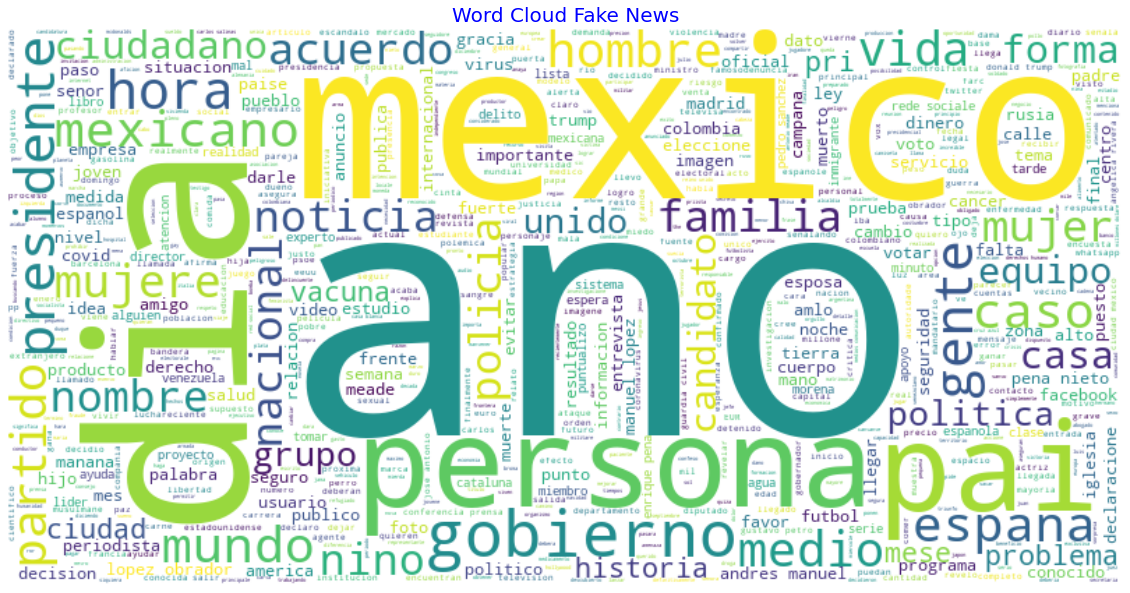

In [ ]:
#Wordcloud 1000 noticias falsas
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(fake_news['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Fake News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Cloud Real News Corpus Mejorado

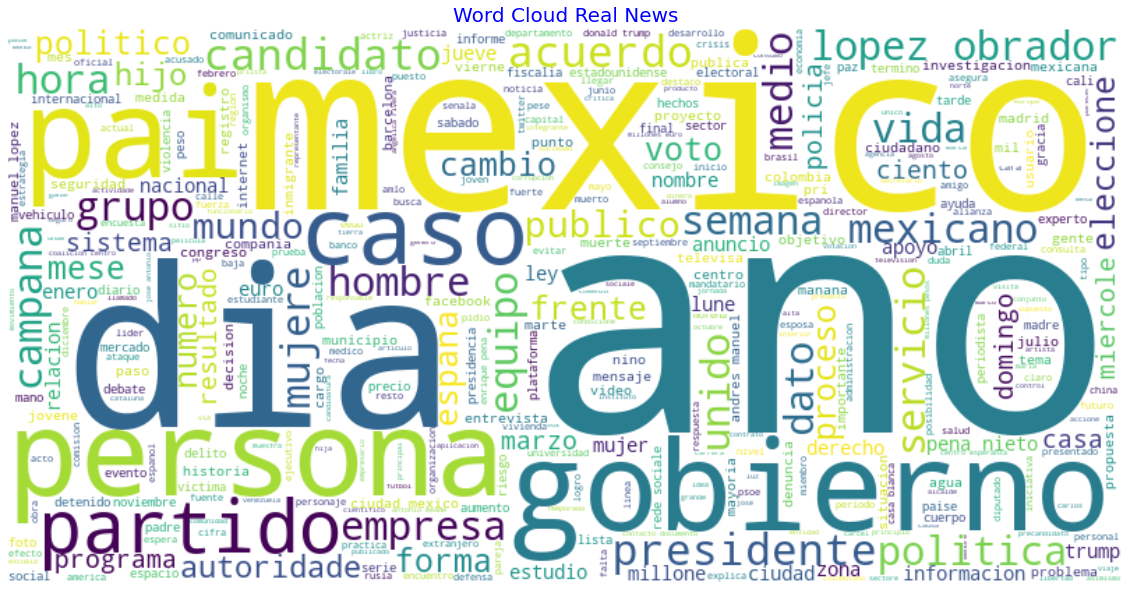

In [ ]:
#Wordcloud 1000 Noticias reales
wc = WordCloud(background_color="white", max_words=3000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(real_news['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Real News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Modelamiento**

## Codificación de etiquetas

In [ ]:
category_codes = {
     'Noticia Real': 0,
    'Noticia Falsa': 1
}

In [ ]:
df_merge['Codigo'] = df_merge['Categoria']
df_merge = df_merge.replace({'Codigo':category_codes})

NameError: ignored

In [ ]:
df_base_cp['Codigo'] = df_base_cp['Categoria']
df_base_cp = df_base_cp.replace({'Codigo':category_codes})

## División de datos

Se realiza el particionamiento de los datos en prueba y validación.

In [ ]:
#Division de datos - Corpus propio
X_train_cp, X_test_cp, y_train_cp, y_test_cp = train_test_split(df_base_cp['Processed_Text'], 
                                                    df_base_cp['Codigo'], 
                                                    test_size=0.20, 
                                                    random_state=8)

In [ ]:
#Division de datos - Corpus de referencia + Corpus creado = 1000 noticias
X_train, X_test, y_train, y_test = train_test_split(df_merge['Processed_Text'], 
                                                    df_merge['Codigo'], 
                                                    test_size=0.20, 
                                                    random_state=8)

## **Representación del texto**

La representación del texto se realiza con sklearn mediante la técnica Tfidf parametrizado con unigramas y bigramas del texto

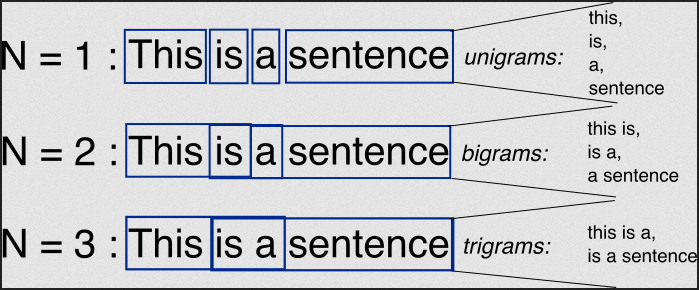

**ngram_range ** tuple (min_n, max_n) default=(1,1): Representa el limite inferior y superior para los n-grams en la extracción del texto ngram_range=(1,2) representa unigrams y bigrams a aplicarse

**max_df** parametros para ignorar terminos demasiado frecuentes que superan el umbral. ejm: max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".

**min_df** parametros para ignorar terminos no frecuentes y que superen un umbral. ejm: min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".

**max_features:** crea un vocabulario que solo tenga el top max_features ordenadas por frecuencia de términos en todo el corpus.

fuente: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


In [ ]:
# Eleccion de parametros
ngram_range = (1,3) # unigrams, bigrams, trigrams
min_df = 0.001 # se eliminan los terminos poco frecuentes que aparezcan como minimo en el 0.1% de los documentos
max_df = 0.8 # se eliminan los terminos demaciado frecuentes que aparezcan en almenos el 80% de los documentos (similar a stopwords).
max_features = 300 # 

In [ ]:
# Corpus Propio
features_train_cp,features_test_cp,labels_train_cp,labels_test_cp,tfidf_cp=tifdf_features(X_train_cp, X_test_cp, y_train_cp, y_test_cp,ngram_range,max_df,min_df,max_features)

In [ ]:
# Corpus Mejorado
features_train,features_test,labels_train,labels_test,tfidf=tifdf_features(X_train, X_test, y_train, y_test,ngram_range,max_df,min_df,max_features)

In [ ]:
print(features_train_cp.shape)
print(features_train.shape)

In [ ]:
count_values = features_train.toarray().sum(axis=0)
# list of ngrams
vocab = tfidf.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
df_ngram

## Modelos de clasificación

Metricas de evaluación

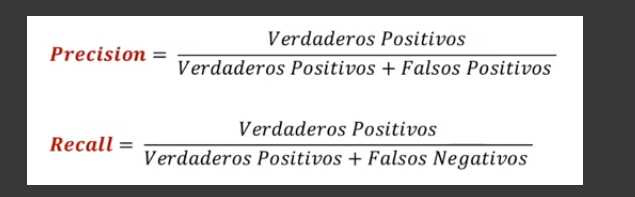

### **RandomForestClassifier**


In [ ]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
hyperparameters_tuning = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(hyperparameters_tuning)

#### **RandomForest Classifier - Corpus del proyecto**

In [ ]:
%%time
# First create the base model to tune
rfc = RandomForestClassifier(random_state=rng)

# Definition of the random search
random_search_cp = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=hyperparameters_tuning,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=rng)

# Fit the random search model
random_search_cp.fit(features_train_cp, labels_train_cp)
print("Mejores hiperparametros:",random_search_cp.best_params_)
print("Accuracy hiperparametros:",random_search_cp.best_score_)

In [ ]:
# se entrena el modelo con los parametros encontrados en la busqueda aleatoria.
clf_cp = RandomForestClassifier(n_estimators=1000, min_samples_split=2,min_samples_leaf=2, max_features='auto', max_depth=None, bootstrap=True)
clf_cp.fit(features_train_cp, labels_train_cp)
clf_predict_cp = clf_cp.predict(features_test_cp)

In [ ]:
# Matrix de confunsión 500 noticias
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, clf_predict_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
accuracy_randomforest_cp=accuracy_score(labels_test_cp, clf_predict_cp)
print("Accuracy Corpus propio",accuracy_randomforest_cp)

In [ ]:
clf_predict_proba_cp = clf_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp, clf_predict_proba_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,clf_predict_proba_cp)

#### **RandomForest Classifier - Corpus Mejorado**

In [ ]:
%%time
# First create the base model to tune
rfc = RandomForestClassifier(random_state=rng)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=hyperparameters_tuning,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=rng)

# Fit the random search model
random_search.fit(features_train, labels_train)
print("Mejores hiperparametros:",random_search.best_params_)
print("Accuracy hiperparametros:",random_search.best_score_)

In [ ]:
# se entrena el modelo con los parametros encontrados en la busqueda aleatoria.
clf = RandomForestClassifier(n_estimators=1000, min_samples_split=2,min_samples_leaf=1, max_features='auto', max_depth=80, bootstrap=True)
clf.fit(features_train, labels_train)
clf_predict = clf.predict(features_test)

In [ ]:
# Matrix de confunsión 1000 noticias
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, clf_predict)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
accuracy_randomforest=accuracy_score(labels_test, clf_predict)
print(accuracy_randomforest)

In [ ]:
clf_predict_proba = clf.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, clf_predict_proba)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,clf_predict_proba)

## **Naive Bayes**

### **Naive Bayes Corpus del proyecto**

In [ ]:
%%time
hyperparameters_tuning ={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),'fit_prior' : [True, False]}
best_model_nb_cp,predictions_nb_cp,accuracy_nb_cp=randomsearchmodels(MultinomialNB(),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

In [ ]:
MultinomialNB().get_params().keys()

In [ ]:
print("Naive Bayes Accuracy Score -> ",accuracy_nb_cp)
print("Mejores hiperparametros NB:",best_model_nb_cp.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_nb_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
predict_nb_cp=best_model_nb_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp, predict_nb_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,predict_nb_cp)

### **Naive Bayes Corpus Mejorado**

In [ ]:
%%time
hyperparameters_tuning ={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),'fit_prior' : [True, False]}
best_model_nb,predictions_nb,accuracy_nb=randomsearchmodels(MultinomialNB(),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)

In [ ]:
print("Naive Bayes Accuracy Score -> ",accuracy_nb)
print("Mejores hiperparametros NB:",best_model_nb.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_nb)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
predict_nb=best_model_nb.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, predict_nb)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,predict_nb)

## **SVC**

### **SVC Corpus del proyecto**

In [ ]:
%%time
hyperparameters_tuning = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf','sigmoid']}
best_model_svc_cp,predictions_svc_cp,accuracy_svc_cp=randomsearchmodels(SVC(probability=True),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

In [ ]:
print("SVM Accuracy Score -> ",accuracy_svc_cp)
print("Mejores hiperparametros SVM:",best_model_svc_cp.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_svc_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
predict_svc_cp=best_model_svc_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp, predict_svc_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,predict_svc_cp)

### **SVC Corpus Mejorado**

In [ ]:
%%time
hyperparameters_tuning = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf','sigmoid']}
best_model_svc,predictions_svc,accuracy_svc=randomsearchmodels(SVC(probability=True),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)                                       

In [ ]:
print("SVM Accuracy Score -> ",accuracy_svc)
print("Mejores hiperparametros SVM:",best_model_svc.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_svc)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
predict_svc=best_model_svc.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, predict_svc)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,predict_svc)

## **Logistic Regression**

### **Logistic Regression Corpus del proyecto**

In [ ]:
%%time
hyperparameters_tuning = {'C':np.logspace(-2,1,100),'penalty':['l2']}
#hyperparameters_tuning = {'C':np.logspace(-2,1,100),'solver': ['newton-cg', 'lbfgs', 'liblinear'],'penalty': ['none', 'l2']}
best_model_logistic_cp,predictions_logistic_cp,accuracy_logistic_cp=randomsearchmodels(LogisticRegression(class_weight='balanced'),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

In [ ]:
print("Logistic Regression Accuracy Score -> ",accuracy_logistic_cp)
print("Mejores hiperparametros LR:",best_model_logistic_cp.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_logistic_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
y_pred_proba_cp= best_model_logistic_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp,y_pred_proba_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,y_pred_proba_cp)

### **Logistic Regression Corpus Mejorado**

In [ ]:
%%time
hyperparameters_tuning = {'C':np.logspace(-2,1,100),'penalty':['l2']}
#hyperparameters_tuning = {'C':np.logspace(-2,1,100),'solver': ['newton-cg', 'lbfgs', 'liblinear'],'penalty': ['none', 'l2']}
best_model_logistic,predictions_logistic,accuracy_logistic=randomsearchmodels(LogisticRegression(class_weight='balanced'),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)

In [ ]:
print("Logistic Regression Accuracy Score -> ",accuracy_logistic)
print("Mejores hiperparametros LR:",best_model_logistic.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_logistic)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
y_pred_proba= best_model_logistic.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test,y_pred_proba)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,y_pred_proba)

## **XGBoost**

### **XGBoost Corpus del proyecto**

In [ ]:
%%time
hyperparameters_tuning={'colsample_bytree' : [0.3, 0.5, 1.0],'gamma' : [0.1, 1, 1.5],'learning_rate' : [0.1, 0.01, 0.05,0.9],'min_child_weight' : [1, 5, 10],'scale_pos_weight' : [1, 2, 4],'subsample' : [0.8, 0.9, 1.0],'n_estimators' : [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],'max_depth' : [3,5,7,9],'reg_alpha':[0.1, 0.01, 0.05],'eta_vals': [0.001, 0.01, 0.1]}
best_model_xgb_cp,predictions_xgb_cp,accuracy_xgb_cp=randomsearchmodels(xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

In [ ]:
print("XGBoost Accuracy Score: ",accuracy_xgb_cp)
print("Mejores hiperparametros XG:",best_model_xgb_cp.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_xgb_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
y_pred_proba_cp= best_model_xgb_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp,y_pred_proba_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,y_pred_proba_cp)

### **XGBoost Corpus Mejorado**

In [ ]:
%%time
hyperparameters_tuning={'colsample_bytree' : [0.3, 0.5, 1.0],'gamma' : [0.1, 1, 1.5],'learning_rate' : [0.1, 0.01, 0.05,0.9],'min_child_weight' : [1, 5, 10],'scale_pos_weight' : [1, 2, 4],'subsample' : [0.8, 0.9, 1.0],'n_estimators' : [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],'max_depth' : [3,5,7,9],'reg_alpha':[0.1, 0.01, 0.05],'eta_vals': [0.001, 0.01, 0.1]}
best_model_xgb,predictions_xgb,accuracy_xgb=randomsearchmodels(xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)

In [ ]:
print("XGBoost Accuracy Score: ",accuracy_xgb)
print("Mejores hiperparametros XG:",best_model_xgb.best_params_)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_xgb)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
y_pred_proba= best_model_xgb.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test,y_pred_proba)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,y_pred_proba)

## **Redes Neuronales**

### **Red Neuronal Corpus del proyecto**

In [ ]:
# create model
#features_train_cp.shape[1] representa el numero de columnas de los datos de entrenamiento.
tf.keras.backend.clear_session()
model = Sequential()
model.add(Dense(12, input_dim=features_train_cp.shape[1], activation='relu'))
model.add(Dense(128 , activation='relu' ))
model.add(Dense(64 , activation='relu' ))
model.add(Dense(64 , activation='relu' ))
model.add(Dense(32 , activation='relu' ))
model.add(Dense(32 , activation='relu' ))
model.add(Dense(8 , activation='relu' ))
model.add(Dense(1 , activation='sigmoid' ))

In [ ]:
# Compile model
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])

In [ ]:
print(features_train_cp.shape)
print(features_test_cp.shape)
print(type(features_train_cp))
print(type(labels_test_cp))
print((features_train_cp.shape[1]))

In [ ]:
dataxTrain=features_train_cp[100:,:]
datayTrain=labels_train_cp[100:]

DataxVal=features_train_cp[:100,:]
DatayVal=labels_train_cp[:100]

print(dataxTrain.shape)
print(datayTrain.shape)
print(DataxVal.shape)
print(DatayVal.shape)

In [ ]:
X_train_nn_cp=dataxTrain.toarray()
y_train_nn_cp=datayTrain.to_numpy()
X_val_nn_cp=DataxVal.toarray()
y_val_nn_cp=DatayVal.to_numpy()  

In [ ]:
print(X_train_nn_cp.shape)
print(y_train_nn_cp.shape)
print(X_val_nn_cp.shape)
print(y_val_nn_cp.shape)

In [ ]:
%%time
# Fit the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40)
entrenamiento=model.fit(x= X_train_nn_cp, 
                        y=y_train_nn_cp,
                        validation_data=(X_val_nn_cp,
                                         y_val_nn_cp),
                        batch_size=32,
                        callbacks=[callback],
                        epochs=200,
                        verbose=1)

In [ ]:
#X_train_cp, X_test_cp, y_train_cp, y_test_cp 
loss, accuracy = model.evaluate(features_test_cp.toarray(), labels_test_cp.to_numpy())

In [ ]:
prediccion=model.predict(features_test_cp)

In [ ]:
y_predict=(prediccion>0.5)
confusion_matrix(labels_test_cp,y_predict)

In [ ]:
print(labels_test_cp.shape)
print(labels_test_cp.shape)

In [ ]:
accuracy_nn_cp=max(entrenamiento.history['val_accuracy'])

In [ ]:
## grafica de la evolución de la funcion de perdida
def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch
  plt.figure(figsize=(10,5))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_accuracy'], label="Val Error")
  #plt.plot(hist['epoch'], hist['mae'], label='MAE')
  #plt.plot(hist['epoch'], hist['val_mae'], label='val MAE')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(entrenamiento)

In [ ]:
## grafica de la evolución de la funcion de perdida
def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch
  plt.figure(figsize=(10,5))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['loss'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'], label="Val Error")
  #plt.plot(hist['epoch'], hist['mae'], label='MAE')
  #plt.plot(hist['epoch'], hist['val_mae'], label='val MAE')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(entrenamiento)

### **Red Neuronal Corpus mejorado**

In [ ]:
DataxVal# create model
#features_train_cp.shape[1] representa el numero de columnas de los datos de entrenamiento.
tf.keras.backend.clear_session()
model = Sequential()
model.add(Dense(12, input_dim=features_train.shape[1], activation='relu'))
model.add(Dense(128 , activation='relu' ))
model.add(Dense(64 , activation='relu' ))
model.add(Dense(64 , activation='relu' ))
model.add(Dense(32 , activation='relu' ))
model.add(Dense(32 , activation='relu' ))
model.add(Dense(8 , activation='relu' ))
model.add(Dense(1 , activation='sigmoid' ))

In [ ]:
# Compile model
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])

In [ ]:
DataxVal=features_train[:529,:]
DatayVal=labels_train[:529]

dataxTrain=features_train[529:,:]
datayTrain=labels_train[529:]

print(dataxTrain.shape)
print(datayTrain.shape)
print(DataxVal.shape)
print(DatayVal.shape)

In [ ]:
X_train_nn_cp=dataxTrain.toarray()
y_train_nn_cp=datayTrain.to_numpy()
X_val_nn_cp=DataxVal.toarray()
y_val_nn_cp=DatayVal.to_numpy()  

In [ ]:
print(X_train_nn_cp.shape)
print(y_train_nn_cp.shape)
print(X_val_nn_cp.shape)
print(y_val_nn_cp.shape)

In [ ]:
%%time
# Fit the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40)
entrenamiento=model.fit(x= X_train_nn_cp, 
                        y=y_train_nn_cp,
                        validation_data=(X_val_nn_cp,
                                         y_val_nn_cp),
                        batch_size=32,
                        callbacks=[callback],
                        epochs=200,
                        verbose=1)

In [ ]:

loss, accuracy = model.evaluate(features_test.toarray(), labels_test.to_numpy())

In [ ]:
prediccion=model.predict(features_test)

In [ ]:
y_predict=(prediccion>0.5)
confusion_matrix(labels_test,y_predict)

In [ ]:
print(features_test.shape)
print(labels_test.shape)

In [ ]:
accuracy_nn_cp=max(entrenamiento.history['val_accuracy'])

In [ ]:
## grafica de la evolución de la funcion de perdida
def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch
  plt.figure(figsize=(10,5))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_accuracy'], label="Val Error")
  #plt.plot(hist['epoch'], hist['mae'], label='MAE')
  #plt.plot(hist['epoch'], hist['val_mae'], label='val MAE')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(entrenamiento)

# **BERT**

###BERT Con corpus preprocesado propio



In [ ]:
# alistamiento de los datos para el entrenamiento con BERT
noticias_falsas=df_base_cp[df_base_cp['Categoria']=='Noticia Falsa']
noticias_verdaderas=df_base_cp[df_base_cp['Categoria']=='Noticia Real']

In [ ]:
new_dataframe_suffle_true=noticias_verdaderas.sample(frac=1)
new_dataframe_suffle_false=noticias_falsas.sample(frac=1)

In [ ]:
new_dataframe_suffle_true

,Categoria,Texto,Processed_Text,Codigo
290,Noticia Real,Expectativa por protagonismo femenino en elec...,expectativa protagonismo femenino eleccione ll...,0
24,Noticia Real,La Procuraduría reveló que después de revisar ...,procuraduria revelo revisar antecedente candid...,0
396,Noticia Real,Vulnerabilidad al cambio climático del sector ...,vulnerabilidad cambio climatico sector empresa...,0
100,Noticia Real,La Policía Nacional española detuvo a un colom...,policia nacional espanola detuvo colombiano ma...,0
358,Noticia Real,Óscar Iván Zuluaga da positivo a covid-20\nEl ...,oscar ivan zuluaga positivo covid candidato ce...,0
...,...,...,...,...
375,Noticia Real,Aumento de penas y otros cambios de nueva Ley...,aumento penas cambios ley seguridad ciudadana ...,0
109,Noticia Real,Unos hombres que vestían prendas alusivas a la...,hombres vestian prendas alusivas policia nacio...,0
457,Noticia Real,"Este miércoles, 26 de enero, se conoció que la...",miercole enero conocio procuraduria regional v...,0
629,Noticia Real,Consejo Nacional Electoral pide auditoría de s...,consejo nacional electoral pide auditoria soft...,0


In [ ]:
new_dataframe_suffle_false

,Categoria,Texto,Processed_Text,Codigo
510,Noticia Falsa,LUTO NACIONAL Acaba de ocurrir un terrible acc...,luto nacional acaba ocurrir terrible accidente...,1
555,Noticia Falsa,GOBIERNO DE EEUU SANCIONA A SANTOS POR ESTA ES...,gobierno eeuu sanciona santos escandalosa noti...,1
228,Noticia Falsa,No estás obligado a vacunarte \nAcuerdo de Núr...,obligado vacunarte acuerdo nuremberg obligar v...,1
207,Noticia Falsa,LA TRISTE HISTORIA DEL BLACK FRIDAY Durante e...,triste historia black friday comercio esclavos...,1
310,Noticia Falsa,"5 empleados del Ara en coma, 4 policías muerto...",empleados ara coma policias muertos uniformado...,1
...,...,...,...,...
71,Noticia Falsa,"ATENCIÓN.\n\nLa Pandemia, bajo la óptica de Ma...",atencion pandemia optica manuel elkin patarrol...,1
196,Noticia Falsa,"el Alto Comisionado para la Paz, Miguel Ceball...",alto comisionado paz miguel ceballos evaluacio...,1
80,Noticia Falsa,Un ojo vale más que una protesta. Mi consejo e...,ojo vale protesta consejo salgan marchar novie...,1
161,Noticia Falsa,Timochenko confirma regreso de Iván Márquez al...,timochenko confirma regreso ivan marquez narco...,1


In [ ]:
print(new_dataframe_suffle_true.shape)
print(new_dataframe_suffle_false.shape)

(317, 4)
(317, 4)


In [ ]:
test_true=new_dataframe_suffle_true.iloc[:60,:]
test_false=new_dataframe_suffle_false.iloc[:60,:]
training_true=new_dataframe_suffle_true.iloc[60:,:]
training_false=new_dataframe_suffle_false.iloc[60:,:]
print(test_true.shape)
print(test_false.shape)
print(training_true.shape)
print(training_false.shape)

(60, 4)
(60, 4)
(257, 4)
(257, 4)


In [ ]:
test_true

,Categoria,Texto,Processed_Text,Codigo
290,Noticia Real,Expectativa por protagonismo femenino en elec...,expectativa protagonismo femenino eleccione ll...,0
24,Noticia Real,La Procuraduría reveló que después de revisar ...,procuraduria revelo revisar antecedente candid...,0
396,Noticia Real,Vulnerabilidad al cambio climático del sector ...,vulnerabilidad cambio climatico sector empresa...,0
100,Noticia Real,La Policía Nacional española detuvo a un colom...,policia nacional espanola detuvo colombiano ma...,0
358,Noticia Real,Óscar Iván Zuluaga da positivo a covid-20\nEl ...,oscar ivan zuluaga positivo covid candidato ce...,0
458,Noticia Real,"\nEl secretario de Seguridad de Cali, Carlos J...",secretario seguridad cali carlos javier soler ...,0
40,Noticia Real,La decisión la confirmó la representante legal...,decision confirmo representante legal colectiv...,0
255,Noticia Real,Partidos y coaliciones inician presentación de...,partidos coalicione inician presentacion integ...,0
339,Noticia Real,"Lo último: Diego Cadena, suspendido 3 años par...",diego cadena suspendido anos ejercer abogado d...,0
347,Noticia Real,Comienza inscripción de candidatos a la presid...,comienza inscripcion candidatos presidencia re...,0


In [ ]:
test_true=test_true.reset_index(drop=True)
test_false=test_false.reset_index(drop=True)

In [ ]:
training_false.Texto.iloc[200]

'Al fin se destapa. ¡Extraordinario! Polonia, Suecia y Noruega están presentando una demanda contra la OMS por infectar a Europa. Los pilotos detenidos han admitido rociar un producto químico que causa neumonitis química'

In [ ]:
# reset de los indices
#noticias_falsas=noticias_falsas.reset_index(drop=True)
#noticias_verdaderas=noticias_verdaderas.reset_index(drop=True)
len_noticias_falsas=len(training_false)
len_noticias_verdaderas=len(training_true)
len_noticias_falsas_test=len(test_false)
len_noticias_verdaderas_test=len(test_true)

In [ ]:
training_false=training_false.reset_index(drop=True)
training_true=training_true.reset_index(drop=True)

In [ ]:
test_false=test_false.reset_index(drop=True)
test_true=test_true.reset_index(drop=True)

In [ ]:
## ver el directorio actual de trabajo
import os
print(os.getcwd())
#os.chdir(os.getcwd())

/content


In [ ]:
# crear  los directorios y separar las noticias de manera individual
os.makedirs('news')
os.chdir('news')
os.makedirs('train')
os.chdir('train')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_falsas), range(len_noticias_falsas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_false['Processed_Text'][i])

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('train')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas), range(len_noticias_verdaderas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_true['Processed_Text'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.makedirs('test')
os.chdir('test')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_false['Processed_Text'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('test')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_true['Processed_Text'][i])
os.chdir('/content')

In [ ]:
# para borra los directorios
import shutil
os.chdir('/content')
#os.chdir('news')

shutil.rmtree('news')

In [ ]:
## se leen las noticias utilizando las utilidades de keras
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'news/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 514 files belonging to 2 classes.
Using 412 files for training.
Found 514 files belonging to 2 classes.
Using 102 files for validation.
Found 120 files belonging to 2 classes.


In [ ]:
# se define la arquitectura de la red neuronal utilizando a BERT para que haga parte del modelo (Fine Tunning)
tf.keras.backend.clear_session()
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

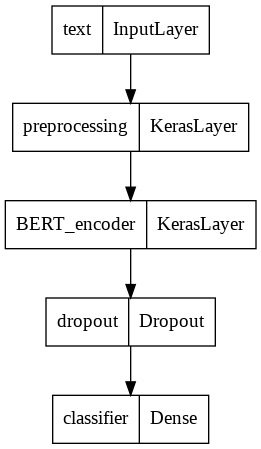

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
# definición de la funcion de perdida y la metrica a utilizar
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# parametrización
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compilación del modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
## entrenamiento del modelo con todas la noticias.
%%time
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/5
13/13 [==============================] - 55s 2s/step - loss: 0.6185 - binary_accuracy: 0.6408 - val_loss: 0.3140 - val_binary_accuracy: 0.8922
Epoch 2/5
13/13 [==============================] - 27s 2s/step - loss: 0.2874 - binary_accuracy: 0.8738 - val_loss: 0.3773 - val_binary_accuracy: 0.8824
Epoch 3/5
13/13 [==============================] - 27s 2s/step - loss: 0.1927 - binary_accuracy: 0.9393 - val_loss: 0.1685 - val_binary_accuracy: 0.9510
Epoch 4/5
13/13 [==============================] - 27s 2s/step - loss: 0.1274 - binary_accuracy: 0.9539 - val_loss: 0.2801 - val_binary_accuracy: 0.9020
Epoch 5/5
13/13 [==============================] - 27s 2s/step - loss: 0.0803 - binary_accuracy: 0.9733 - val_loss: 0.1744 - val_binary_accuracy: 0.9412
CPU times: user 1min 43s, sys: 26.2 s, total: 2min 10s
Wall time: 3min 9s


In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


4/4 [==============================] - 3s 624ms/step - loss: 0.4287 - binary_accuracy: 0.8833
Loss: 0.4286675751209259
Accuracy: 0.8833333253860474


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


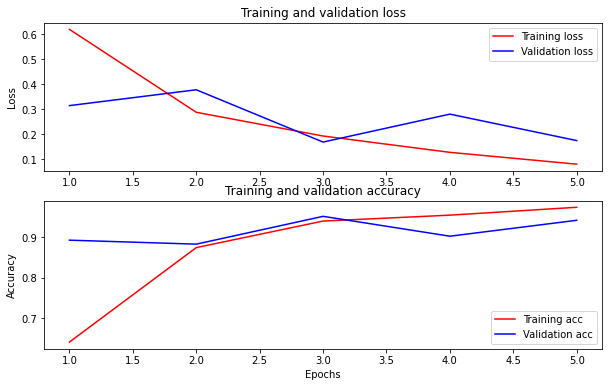

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'noticias'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

In [ ]:
os.getcwd()

'/content'

In [ ]:
classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./noticias_bert/assets


INFO:tensorflow:Assets written to: ./noticias_bert/assets


In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def pruebasPrediccion(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

In [ ]:
examples = [
    'Decretan calamidad pública por ola invernal en Cundinamarca', 
    'Tasas de interés podrían ubicarse en el 6%, para finales de abril',
    'Con el hundimiento del proyecto de reforma al Código Electoral en la Corte Constitucional, por considerar que se presentaron vicios de trámite en el Congreso, no solamente se pierden dos años de trabajo que se invirtieron en este tema, sino que los ajustes que contenía podrían quedarse, ahora en una nueva iniciativa, para ser aplicados hasta las elecciones presidenciales de 2026.',
    'Fallece presidente Donal trump abatido por sicarios sirios. Tenemos las primeras imagenes del cuerpo',
    'Posibles narcotraficantes están financiando campaña a la presidencia de Federico Gutiérrez.El caso que implica a Federico Gutiérrez y otros funcionarios lo anunció la Procuraduría General',
    'En una entrevista reciente, se le preguntó al candidata Gustavo Perro: ¿Cree que hay un Dios? Su respuesta fue :  Mi sistema de creencias no apoya a un creador como tal" Dios fue una figura imaginaria creada por el hombre. ¿Alguien lo ha visto? Si alguien tiene pruebas concretas de su existencia, lo desafio a que me las muestre. Lo que tenemos son simplemente teorías inventadas por el hombre. La gente vive engañada pensando que Dios nos creo y no es así. El candidato Gustavo Peto concluyo: Entonces, si usted me pregunta si existe un Diesel creo en un Dios humana y no sobrehumano.y lo creo, es porque creo que yo soy Dios.',
    'En una iglesia ucraniana que quedó totalmente destruida, solo quedó intacta la imagen de Cristo resucitado. Si esto no son signos de los tiempos, entonces ¿Qué es? Esta imagen de Cristo nos lo recuerda, resucitando de los escombros, como signo de esperanza. Podrán destruir templos, pero la fe jamás. Cristo nos repite Yo soy la resurrección y la vida',
    'Vendedores del Palacio del Colesterol viven con el temor a que desaparezca',
    'A comienzos de este mes reabrió sus puertas, tras dos años de quiebra y desolación, la popular plazoleta de comidas ubicada a las espaldas de El Campín y que, durante las últimas seis décadas, se convirtió en un refugio cálido para que los hinchas del fútbol, tras el último pitazo de un partido, tuvieran un lugar en el que pudieran seguir hablando de un tema: fútbol, por supuesto.',
    'las palomas tienen más proteínas, en Suecia comen palomas, comiendo palomas no sacrifican tantos pollos Fenavi paraco',
    'Q tristeza q tengan q pagar gente inocente, y solo buscan culpables y dicen que es petro a medrantando ala gente es mentira es el gobierno de uribe q casualidad q para elecciones pasen tantas cosas, y si ganan los uribistas nu hay terrorismo',
    'el candidato @FicoGutierrez dice que subiría los impuestos a las motos además de poner peajes urbanos y pico y placa todo el día en el país para mejorar la seguridad',
    'Posibles narcotraficantes están financiando campaña a la presidencia de Federico Gutiérrez',
    '¿Ahora entienden por qué solo aparecen votos para favorecer al terrorista indultado? Este tipo es el único que puede a Fico con fraude y por eso debe ser destituido de su cargo antes de las presidenciales',
    'Y con ustedes desde las filas de las Farc, la narco terrorista',
    'Si Usted depende para VIVIR del Arriendo de un Apartamentico o Casa que Compro con el Trabajo de Años, Valla Olvidandose por que Petro el ( Chávez Colombiano) se la va a Expropiar',
    'Las iglesias evangélicas en Colombia, deberían tener control y límites, además deberían pagar impuestos como cualquier empresa (sic)',
    'Los costeños son la población menos intelectual del país , es por eso que esta región de Colombia está sumida en la pobreza. Tampoco les gusta trabajar por eso hay en estos momentos hay un nivel muy alto de miseria en la guajira . Con el centro democrático cambiaremos (sic)',
    'Esta es la verdadera razón C del fallo sobre el aborto. Le lavan los crímenes a los amigos ideológicos de las FARC. Rosa blanca denunció a las FARC ante la CPI por los abortos obligados a niñas reclutadas. Pero con ese fallo de la CConstitucional, el delito de las FARC desaparece. Entienden? Por eso la declaración de Andrés Pastrana . El fallo de la corte es un fallo político.',
    '50 mil camioneros han empezado a rodear el parlamento canadiense en Ottawa y tienen la consigna de no moverse hasta acabar con el pasaporte sanitario y poner de rodillas a Trudeau hasta lograr su dimisión',
    'Ministerio de Nacional de Defensa China, Tan Kefei, anunció que en cualquier momento, y en cualquier lugar están dispuestos a apoyar a Rusia en caso de que EE.UU y la OTAN quieran intervenir 😖🤔… AH PERO FUERON TODOS A LAS OLIMPIADAS A CELEBRARLE EL VIRUS Y MUERTES',
    'LUTO NACIONAL Acaba de ocurrir un terrible accidente aéreo de un avión de pasajeros. No hubo sobrevivientes. Un conductor grabó el video desde su auto',
    'en plenaria del senado intentarán quitarle la pensión a las esposas de los que fallecen y a los hijos especiales',
    'Argentina: La ANMAT reconoce que las vacunas contienen grafeno,',
    'Se anuló la vacunación universal. Una gran victoria para la libertad, la Corte Suprema anuló la vacunación universal',
    'Recuerdan lo de las 10 millones de firmas para rebajar los sueldos de los congresistas? Esas firmas fueron aprobadas y fue aprobada también la consulta. Ahora nos corresponde a nosotros votar este 11 de marzo para que se haga efectiva y sea aprobada y llegue al congreso sin modificaciones',
    'A comienzos de este mes reabrió sus puertas, tras dos años de quiebra y desolación, la popular plazoleta de comidas ubicada a las espaldas de El Campín',
    'La Fiscalía informó este lunes que pidió el retiro del preacuerdo al que llegó con Jhonier Leal, por el doble homicidio de su hermano, el estilista Mauricio Leal, y su madre Marleni Hernández.',
    'La Fiscalía informó este lunes que pidió el retiro del preacuerdo al que llegó con Jhonier Leal, por el doble homicidio de su hermano, el estilista Mauricio Leal, y su madre Marleni Hernández. Todo se debe a las declaraciones del acusado la semana pasada, al retractarse de aceptar los cargos al denunciar una supuesta presión por parte del ente acusador, para que firmara el preacuerdo.',
    'El candidato presidencial Luis Pérez negó las acusaciones que hizo el excabecilla del Clan del Golfo, alias Otoniel, donde señaló que tenía nexos con paramilitares, en concreto con alias Mi Sangre, un  narcotraficante, considerado como uno de los capos de la Oficina de Envigado.'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
print('Results from the saved model:')
pruebasPrediccion(examples, reloaded_results)

Results from the saved model:
input: Decretan calamidad pública por ola invernal en Cundinamarca : score: 0.007332
input: Tasas de interés podrían ubicarse en el 6%, para finales de abril : score: 0.083372
input: Con el hundimiento del proyecto de reforma al Código Electoral en la Corte Constitucional, por considerar que se presentaron vicios de trámite en el Congreso, no solamente se pierden dos años de trabajo que se invirtieron en este tema, sino que los ajustes que contenía podrían quedarse, ahora en una nueva iniciativa, para ser aplicados hasta las elecciones presidenciales de 2026. : score: 0.477488
input: Fallece presidente Donal trump abatido por sicarios sirios. Tenemos las primeras imagenes del cuerpo : score: 0.019615
input: Posibles narcotraficantes están financiando campaña a la presidencia de Federico Gutiérrez.El caso que implica a Federico Gutiérrez y otros funcionarios lo anunció la Procuraduría General : score: 0.327614
input: En una entrevista reciente, se le pregun

###BERT Con corpus preprocesado unido



In [ ]:
# alistamiento de los datos para el entrenamiento con BERT
noticias_falsas=df_merge[df_merge['Categoria']=='Noticia Falsa']
noticias_verdaderas=df_merge[df_merge['Categoria']=='Noticia Real']

In [ ]:
new_dataframe_suffle_true=noticias_verdaderas.sample(frac=1)
new_dataframe_suffle_false=noticias_falsas.sample(frac=1)

In [ ]:
new_dataframe_suffle_true

,Unnamed: 0,Categoria,Texto,Processed_Text
1234,600,Noticia Real,Karla Souza rompe el silencio en sus redes soc...,karla souza rompe silencio rede sociale testim...
345,345,Noticia Real,Precandidatos aceleran desarrollo de campañas...,precandidatos aceleran desarrollo campanas pai...
2544,1234,Noticia Real,La síndica de Unides Podem en Les Corts Valenc...,sindica unides podem corts valencianes naiara ...
2628,1318,Noticia Real,Los barones chocan con Pablo Casado por negarl...,barones chocan pablo casado negarles giro centro
3250,1940,Noticia Real,La Intervención de la Generalitat también cues...,intervencion generalitat cuestiona informe aud...
...,...,...,...,...
2651,1341,Noticia Real,Los mejores momentos del desfile de Victoria's...,mejore momentos desfile victoria secret shangh...
2505,1195,Noticia Real,La Policía Nacional de Ceuta ha detenido en la...,policia nacional ceuta detenido horas personas...
1296,662,Noticia Real,CHICHARITO 'ENCIENDE' EL INSTAGRAM DE YUYA\nEl...,chicharito enciende instagram yuya atacante me...
1275,641,Noticia Real,Fernando Colunga reaparece tras un largo perio...,fernando colunga reaparece periodo ausente luc...


In [ ]:
new_dataframe_suffle_false

,Unnamed: 0,Categoria,Texto,Processed_Text
221,221,Noticia Falsa,El gobierno de Colombia acaba de hacer oficial...,gobierno colombia acaba oficial ciudadanos col...
3174,1864,Noticia Falsa,QUE DICE MI HERMANA QUE SE HA MUERTO JOHNNY DEPP,hermana muerto johnny depp
2358,1048,Noticia Falsa,La animadversión de la izquierda española haci...,animadversion izquierda espanola simbolo litur...
1757,447,Noticia Falsa,con Franco Podemos no existiría y si fuera así...,franco existiria miles enterrados cunetas
2530,1220,Noticia Falsa,La realidad siempre supera a la ficción. Una m...,realidad supera ficcion mujer atraganto semen ...
...,...,...,...,...
1049,415,Noticia Falsa,"Meade por fin toma una decisión: ""Creo que vot...",meade toma decision votare candidato pri presi...
1842,532,Noticia Falsa,El Amazonas venezolano lleva años siendo explo...,amazonas venezolano anos explotado gracias dic...
1322,12,Noticia Falsa,Estamos en la semana decisiva. Los expertos as...,semana decisiva expertos aseguran campana elec...
533,533,Noticia Falsa,Entre las nueve personas muertas en el bombard...,nueve personas muertas bombardeo duque caqueta...


In [ ]:
print(new_dataframe_suffle_true.shape)
print(new_dataframe_suffle_false.shape)

In [ ]:
test_true=new_dataframe_suffle_true.iloc[:331,:]
test_false=new_dataframe_suffle_false.iloc[:331,:]
training_true=new_dataframe_suffle_true.iloc[331:,:]
training_false=new_dataframe_suffle_false.iloc[331:,:]
print(test_true.shape)
print(test_false.shape)
print(training_true.shape)
print(training_false.shape)

(331, 4)
(331, 4)
(1324, 4)
(1324, 4)


In [ ]:
test_true

,Unnamed: 0,Categoria,Texto,Processed_Text
1234,600,Noticia Real,Karla Souza rompe el silencio en sus redes soc...,karla souza rompe silencio rede sociale testim...
345,345,Noticia Real,Precandidatos aceleran desarrollo de campañas...,precandidatos aceleran desarrollo campanas pai...
2544,1234,Noticia Real,La síndica de Unides Podem en Les Corts Valenc...,sindica unides podem corts valencianes naiara ...
2628,1318,Noticia Real,Los barones chocan con Pablo Casado por negarl...,barones chocan pablo casado negarles giro centro
3250,1940,Noticia Real,La Intervención de la Generalitat también cues...,intervencion generalitat cuestiona informe aud...
...,...,...,...,...
2056,746,Noticia Real,"El presidente del Gobierno en funciones, Pedro...",presidente gobierno funciones pedro sanchez re...
1811,501,Noticia Real,Dos detenidos en un pueblo de Alicante acusado...,detenidos pueblo alicante acusados paliza pare...
8,8,Noticia Real,Canciller propone a Cuba agenda de mutua confi...,canciller propone cuba agenda mutua confianza ...
1399,89,Noticia Real,El fabricante japonés de vehículos Nissan Mot...,fabricante japones vehiculos nissan motor regi...


In [ ]:
training_true.Processed_Text.iloc[256]

'unam capacitara maestros aprobar prueba pisa maxima casa estudio sep firmaron convenios facultades ciencia quimica instituto matematicas ensenen profesores estrategias impartir disciplinas alumnos preescolar primaria secundaria universidad nacional autonoma mexico unam capacitara profesores educacion obligatoria matematicas ciencias lectura ensenanza materias escuelas publicas necesidad mejorar resultados mexico pruebas internacionale aprovechamiento escolar pisa firma convenio general especificos colaboracion universidad nacional secretaria educacion publica sep rector enrique graue wiecher objetivos instrumentos facultades ciencia quimica instituto matematicas maxima casa estudio colaboren dependencia federal ofrecer cursos capacitacion maestros mexicanos'

In [ ]:
training_false.Processed_Text.iloc[200]

'frutas contagiaron vih mensajes alerta circulando rede sociale advierten cuidado naranjas platanos frutas inyectadas sangre portadora vih virus inmunodeficiencia humana activo desarrolla sida noticia compartido febrero habla fruta libia incautada argelia incautaron platanos infectados virus logicamente malintencionado rumor viene adaptacion moderna leyendas urbanas comida infectada virus llevan difundiendose snopes pagina web especializada desmentir bulos noticias falsas rumor naranjas origen foro argeliano fotos diciembre salto paginas facebook argelia acabo traducido ingle febrero dia apareciera espanol terminar esclarecer rumore importante datos empecemos aclarar naranjas platanos infectados sangre portadora vih contagiarse virus transmite doctor pep coll fundacion lucha sida tajante virus sobrevivir cuerpo humano comieramos naranjas platanos probable siquiera existan virus muerto contagiariamos anade snopes cita pagina centro control enfermedades unidos afirma forma transmitir vir

In [ ]:
len_noticias_falsas=len(training_false)
len_noticias_verdaderas=len(training_true)
len_noticias_falsas_test=len(test_false)
len_noticias_verdaderas_test=len(test_true)

In [ ]:
training_false=training_false.reset_index(drop=True)
training_true=training_true.reset_index(drop=True)

In [ ]:
test_false=test_false.reset_index(drop=True)
test_true=test_true.reset_index(drop=True)

In [ ]:
## ver el directorio actual de trabajo
import os
print(os.getcwd())
#os.chdir(os.getcwd())

/content


In [ ]:
# para borra los directorios
import shutil
os.chdir('/content')
#os.chdir('news')
shutil.rmtree('news')

In [ ]:
training_false.shape

(1324, 4)

In [ ]:
# crear  los directorios y separar las noticias de manera individual
os.makedirs('news')
os.chdir('news')
os.makedirs('train')
os.chdir('train')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_falsas), range(len_noticias_falsas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_false['Processed_Text'][i])

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('train')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas), range(len_noticias_verdaderas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_true['Processed_Text'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.makedirs('test')
os.chdir('test')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_false['Processed_Text'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('test')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_true['Processed_Text'][i])
os.chdir('/content')

In [ ]:
# para borra los directorios
#import shutil
#os.chdir('/content')
#os.chdir('news')
#shutil.rmtree('test')

In [ ]:
## se leen las noticias utilizando las utilidades de keras
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'news/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 2648 files belonging to 2 classes.
Using 2119 files for training.
Found 2648 files belonging to 2 classes.
Using 529 files for validation.
Found 662 files belonging to 2 classes.


In [ ]:
# se define la arquitectura de la red neuronal utilizando a BERT para que haga parte del modelo (Fine Tunning)
tf.keras.backend.clear_session()
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='relu', name='classifier')(net)
  return tf.keras.Model(text_input, net)

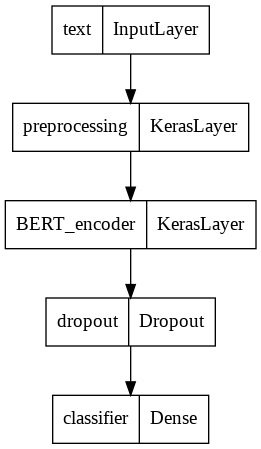

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
# definición de la funcion de perdida y la metrica a utilizar
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# parametrización
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compilación del modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
## entrenamiento del modelo con todas la noticias.
%%time
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/20
67/67 [==============================] - 92s 1s/step - loss: 0.6804 - binary_accuracy: 0.5465 - val_loss: 0.6447 - val_binary_accuracy: 0.6314
Epoch 2/20
67/67 [==============================] - 68s 1s/step - loss: 0.6439 - binary_accuracy: 0.6791 - val_loss: 0.6258 - val_binary_accuracy: 0.6616
Epoch 3/20
67/67 [==============================] - 68s 1s/step - loss: 0.6173 - binary_accuracy: 0.7272 - val_loss: 0.8653 - val_binary_accuracy: 0.7032
Epoch 4/20
67/67 [==============================] - 68s 1s/step - loss: 0.6261 - binary_accuracy: 0.7504 - val_loss: 0.7637 - val_binary_accuracy: 0.7202
Epoch 5/20
67/67 [==============================] - 68s 1s/step - loss: 0.5397 - binary_accuracy: 0.8249 - val_loss: 0.7587 - val_binary_accuracy: 0.7618
Epoch 6/20
67/67 [==============================] - 68s 1s/step - loss: 0.5725 - binary_accuracy: 0.8160 - val_loss: 0.6018 - val_binary_accuracy:

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


21/21 [==============================] - 7s 321ms/step - loss: 1.2661 - binary_accuracy: 0.7447
Loss: 1.266050934791565
Accuracy: 0.7447130084037781


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


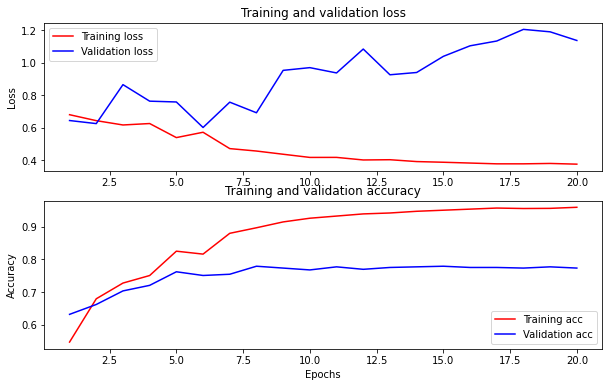

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### BERT con corpus propio sin preprocesar



In [ ]:
# alistamiento de los datos para el entrenamiento con BERT
noticias_falsas=df_base_cp[df_base_cp['Categoria']=='Noticia Falsa']
noticias_verdaderas=df_base_cp[df_base_cp['Categoria']=='Noticia Real']

In [ ]:
new_dataframe_suffle_true=noticias_verdaderas.sample(frac=1)
new_dataframe_suffle_false=noticias_falsas.sample(frac=1)

In [ ]:
new_dataframe_suffle_true['Texto'].iloc[100]

' Mayorquín citado a audiencia pública el 3 de febrero.\nEl director del DAPRE, Víctor Muñoz, indicó que Andrés Mayorquín, ex exasesor presidencial, fue llamado a rendir declaratoria el próximo 3 de febrero, por el presunto caso de tráfico de influencias. '

In [ ]:
new_dataframe_suffle_false

,Categoria,Texto,Processed_Text
510,Noticia Falsa,LUTO NACIONAL Acaba de ocurrir un terrible acc...,luto nacional acaba ocurrir terrible accidente...
555,Noticia Falsa,GOBIERNO DE EEUU SANCIONA A SANTOS POR ESTA ES...,gobierno eeuu sanciona santos escandalosa noti...
228,Noticia Falsa,No estás obligado a vacunarte \nAcuerdo de Núr...,obligado vacunarte acuerdo nuremberg obligar v...
207,Noticia Falsa,LA TRISTE HISTORIA DEL BLACK FRIDAY Durante e...,triste historia black friday comercio esclavos...
310,Noticia Falsa,"5 empleados del Ara en coma, 4 policías muerto...",empleados ara coma policias muertos uniformado...
...,...,...,...
71,Noticia Falsa,"ATENCIÓN.\n\nLa Pandemia, bajo la óptica de Ma...",atencion pandemia optica manuel elkin patarrol...
196,Noticia Falsa,"el Alto Comisionado para la Paz, Miguel Ceball...",alto comisionado paz miguel ceballos evaluacio...
80,Noticia Falsa,Un ojo vale más que una protesta. Mi consejo e...,ojo vale protesta consejo salgan marchar novie...
161,Noticia Falsa,Timochenko confirma regreso de Iván Márquez al...,timochenko confirma regreso ivan marquez narco...


In [ ]:
print(new_dataframe_suffle_true.shape)
print(new_dataframe_suffle_false.shape)

(317, 3)
(317, 3)


In [ ]:
test_true=new_dataframe_suffle_true.iloc[:60,:]
test_false=new_dataframe_suffle_false.iloc[:60,:]
training_true=new_dataframe_suffle_true.iloc[60:,:]
training_false=new_dataframe_suffle_false.iloc[60:,:]
print(test_true.shape)
print(test_false.shape)
print(training_true.shape)
print(training_false.shape)

(60, 3)
(60, 3)
(257, 3)
(257, 3)


In [ ]:
test_true

,Categoria,Texto,Processed_Text
290,Noticia Real,Expectativa por protagonismo femenino en elec...,expectativa protagonismo femenino eleccione ll...
24,Noticia Real,La Procuraduría reveló que después de revisar ...,procuraduria revelo revisar antecedente candid...
396,Noticia Real,Vulnerabilidad al cambio climático del sector ...,vulnerabilidad cambio climatico sector empresa...
100,Noticia Real,La Policía Nacional española detuvo a un colom...,policia nacional espanola detuvo colombiano ma...
358,Noticia Real,Óscar Iván Zuluaga da positivo a covid-20\nEl ...,oscar ivan zuluaga positivo covid candidato ce...
458,Noticia Real,"\nEl secretario de Seguridad de Cali, Carlos J...",secretario seguridad cali carlos javier soler ...
40,Noticia Real,La decisión la confirmó la representante legal...,decision confirmo representante legal colectiv...
255,Noticia Real,Partidos y coaliciones inician presentación de...,partidos coalicione inician presentacion integ...
339,Noticia Real,"Lo último: Diego Cadena, suspendido 3 años par...",diego cadena suspendido anos ejercer abogado d...
347,Noticia Real,Comienza inscripción de candidatos a la presid...,comienza inscripcion candidatos presidencia re...


In [ ]:
len_noticias_falsas=len(training_false)
len_noticias_verdaderas=len(training_true)
len_noticias_falsas_test=len(test_false)
len_noticias_verdaderas_test=len(test_true)

In [ ]:
print(len(training_false))
print(len(training_true))
print(len(test_false))
print(len(test_true))

257
257
60
60


In [ ]:
training_false=training_false.reset_index(drop=True)
training_true=training_true.reset_index(drop=True)

In [ ]:
test_false=test_false.reset_index(drop=True)
test_true=test_true.reset_index(drop=True)

In [ ]:
## ver el directorio actual de trabajo
import os
print(os.getcwd())
#os.chdir(os.getcwd())

/content


In [ ]:
# para borra los directorios
import shutil
os.chdir('/content')
#os.chdir('news')
shutil.rmtree('news')

In [ ]:
# crear  los directorios y separar las noticias de manera individual
os.makedirs('news')
os.chdir('news')
os.makedirs('train')
os.chdir('train')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_falsas), range(len_noticias_falsas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_false['Texto'][i])

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('train')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas), range(len_noticias_verdaderas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_true['Texto'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.makedirs('test')
os.chdir('test')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_false['Texto'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('test')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_true['Texto'][i])
os.chdir('/content')

In [ ]:
# para borra los directorios
#import shutil
#os.chdir('/content')
#os.chdir('news')
#shutil.rmtree('test')

In [ ]:
## se leen las noticias utilizando las utilidades de keras
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'news/test',
    batch_size=batch_size)

label_class_names = test_ds.class_names

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 514 files belonging to 2 classes.
Using 412 files for training.
Found 514 files belonging to 2 classes.
Using 102 files for validation.
Found 120 files belonging to 2 classes.


In [ ]:
# se define la arquitectura de la red neuronal utilizando a BERT para que haga parte del modelo (Fine Tunning)
tf.keras.backend.clear_session()
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='relu', name='classifier')(net)
  return tf.keras.Model(text_input, net)

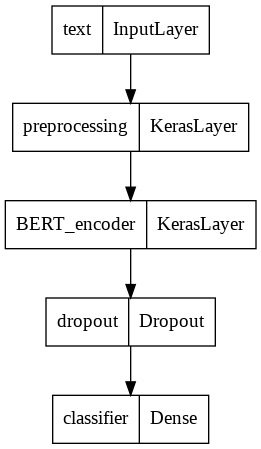

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
# definición de la funcion de perdida y la metrica a utilizar
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# parametrización
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compilación del modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
## entrenamiento del modelo con todas la noticias.
%%time
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/20
13/13 [==============================] - 39s 994ms/step - loss: 0.6933 - binary_accuracy: 0.5146 - val_loss: 0.6931 - val_binary_accuracy: 0.4510
Epoch 2/20
13/13 [==============================] - 12s 947ms/step - loss: 0.6966 - binary_accuracy: 0.5316 - val_loss: 0.6432 - val_binary_accuracy: 0.5588
Epoch 3/20
13/13 [==============================] - 13s 969ms/step - loss: 0.5765 - binary_accuracy: 0.7937 - val_loss: 0.4053 - val_binary_accuracy: 0.9412
Epoch 4/20
13/13 [==============================] - 13s 976ms/step - loss: 0.4288 - binary_accuracy: 0.9587 - val_loss: 0.4842 - val_binary_accuracy: 0.9216
Epoch 5/20
13/13 [==============================] - 13s 990ms/step - loss: 0.4312 - binary_accuracy: 0.9660 - val_loss: 0.4622 - val_binary_accuracy: 0.9412
Epoch 6/20
13/13 [==============================] - 13s 991ms/step - loss: 0.3937 - binary_accuracy: 0.9830 - val_loss: 0.5097 - va

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


4/4 [==============================] - 1s 304ms/step - loss: 0.4613 - binary_accuracy: 0.9583
Loss: 0.46129265427589417
Accuracy: 0.9583333134651184


In [ ]:
#labels =  np.array([])
#predictions =  np.array([])
#for x, y in test_ds:
#  predictions = np.concatenate([predictions, classifier_model.predict(x)])
#  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])


In [ ]:
prediccion=classifier_model.predict(test_ds)

In [ ]:
prediccion

In [ ]:
#y_predict=(prediccion>0.5)
#confusion_matrix(labels_test,y_predict)

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


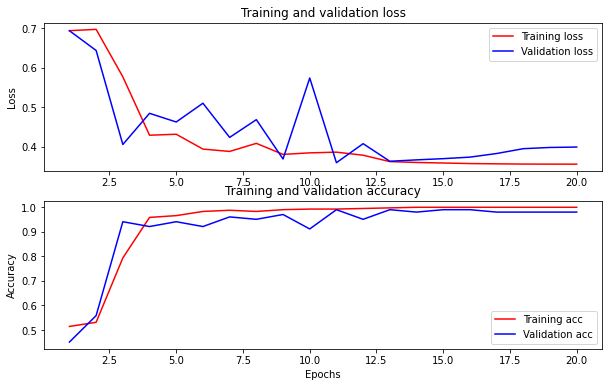

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'noticiasColombianas'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)


INFO:tensorflow:Assets written to: ./noticiasColombianas_bert/assets


INFO:tensorflow:Assets written to: ./noticiasColombianas_bert/assets


In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def pruebas(df,results):
  df_noticias=[]
  for i in tqdm(range(len(df))):
    if(results[i][0]>0.5):
      df_noticias.append(True)
    else:
      df_noticias.append(False)
  return df_noticias

In [ ]:
def pruebasPrediccion(inputs, results):
    return results[i][0]
             

In [ ]:
def classification_news_(df):
  df_noticias=[]
  for noticia in tqdm(df):
    df_noticias.append(detection_fake_news_(noticia))
  return df_noticias

In [ ]:
df_testNoticiasColombianas

,Etiqueta,Texto
0,False,Posibles narcotraficantes están financiando ca...
1,False,"En una entrevista reciente, se le preguntó al..."
2,False,En una iglesia ucraniana que quedó totalmente ...
3,False,"las palomas tienen más proteínas, en Suecia co..."
4,False,"Q tristeza q tengan q pagar gente inocente, y..."
5,False,¿Ahora entienden por qué solo aparecen votos p...
6,False,Si Usted depende para VIVIR del Arriendo de un...
7,False,Los costeños son la población menos intelectua...
8,False,Esta es la verdadera razón C del fallo sobre e...
9,False,LUTO NACIONAL Acaba de ocurrir un terrible acc...


In [ ]:
reloaded_results = tf.sigmoid(reloaded_model(tf.constant(df_testNoticiasColombianas['Texto'])))
print('Results from the saved model:')
df_result_BERT=pruebas(df_testNoticiasColombianas['Texto'], reloaded_results)

Results from the saved model:


100%|██████████| 32/32 [00:00<00:00, 84.59it/s]


In [ ]:
val_label=df_testNoticiasColombianas['Etiqueta']

Text(39.49999999999999, 0.5, 'Predicted')

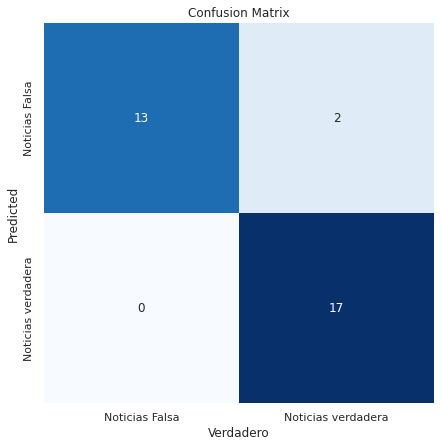

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(val_label, df_result_BERT)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf


,Noticias Falsa,Noticias verdadera
Noticias Falsa,13,2
Noticias verdadera,0,17


In [ ]:
print(classification_report(val_label,df_result_BERT, target_names=['Noticia verdadera','Noticia Falsa']))


                   precision    recall  f1-score   support

Noticia verdadera       1.00      0.87      0.93        15
    Noticia Falsa       0.89      1.00      0.94        17

         accuracy                           0.94        32
        macro avg       0.95      0.93      0.94        32
     weighted avg       0.94      0.94      0.94        32



### BERT con corpus unido sin preprocesar



In [ ]:
# alistamiento de los datos para el entrenamiento con BERT
noticias_falsas=df_base[df_base['Categoria']=='Noticia Falsa']
noticias_verdaderas=df_base[df_base['Categoria']=='Noticia Real']

In [ ]:
new_dataframe_suffle_true=noticias_verdaderas.sample(frac=1)
new_dataframe_suffle_false=noticias_falsas.sample(frac=1)

In [ ]:
new_dataframe_suffle_true['Texto'].iloc[360]

'Respetamos y veneramos a la Virgen de Guadalupe: AMLO\nLa difusión a través de redes sociales de volantes en que supuestamente el partido Morena acusa a la Iglesia Católica de ser parte de la llamada "mafia del poder" fue rechazada por Andrés Manuel López Obrador.\nEl candidato de la coalición Juntos Haremos Historia a la presidencia de la República dijo que su movimiento social es incluyente y respeta la libertad de credos y la veneración a la Virgen de Guadalupe.\nEstán pasando ahora unos volantes que dicen que estamos en contra de La Virgen de Guadalupe, es una campaña vil, sucia.\n"Somos respetuosos de la libertad de creencia", puntualizó López Obrador.\nLos volantes fueron difundidos mediante fotografías en redes sociales, y en ellos se plantea que la iglesia fanatiza a la población, práctica que Morena impediría en caso que el tabasqueño obtenga la presidencia.\nYo estoy muy consciente que el pueblo de México tiene veneración por la Virgen de Guadalupe, tiene veneración por Juár

In [ ]:
new_dataframe_suffle_false

,Unnamed: 0,Categoria,Texto,Processed_Text,Codigo
2313,1003,Noticia Falsa,Increíble pero cierto. En unos grandes almacen...,increible almacenes ciudad alemana turba musul...,Noticia Falsa
757,123,Noticia Falsa,Facebook cobrará manejo de cuenta si no se cub...,facebook cobrara manejo cubre minimo post cono...,Noticia Falsa
2300,990,Noticia Falsa,"HOLA CONTACTOS DE FACEBOOK, ESTA RATA DE ALCAN...",hola contactos facebook rata alcantarilla qued...,Noticia Falsa
3155,1845,Noticia Falsa,Este video de policías cogiendo móviles y de t...,video policias cogiendo moviles tienda corrien...,Noticia Falsa
2695,1385,Noticia Falsa,"Matan a la madre, la descuartizan y aún con la...",matan madre descuartizan carne caliente coloca...,Noticia Falsa
...,...,...,...,...,...
783,149,Noticia Falsa,PAPA FRANCISCO ANUNCIA LANZAMIENTO DE APP PARA...,papa francisco anuncia lanzamiento app ligar i...,Noticia Falsa
219,219,Noticia Falsa,Buenas noticias! Vacuna contra virus Carona li...,noticias vacuna virus carona lista capaz curar...,Noticia Falsa
2559,1249,Noticia Falsa,La transmisión de un caso de sarna a una agent...,transmision caso sarna agente autoridad centro...,Noticia Falsa
52,52,Noticia Falsa,De ultima hora Fuerte Sismo de 82 grados sacud...,hora fuerte sismo grados sacude argentina imag...,Noticia Falsa


In [ ]:
print(new_dataframe_suffle_true.shape)
print(new_dataframe_suffle_false.shape)

(1655, 5)
(1655, 5)


In [ ]:
test_true=new_dataframe_suffle_true.iloc[:331,:]
test_false=new_dataframe_suffle_false.iloc[:331,:]
training_true=new_dataframe_suffle_true.iloc[331:,:]
training_false=new_dataframe_suffle_false.iloc[331:,:]
print(test_true.shape)
print(test_false.shape)
print(training_true.shape)
print(training_false.shape)

(331, 5)
(331, 5)
(1324, 5)
(1324, 5)


In [ ]:
test_true

,Unnamed: 0,Categoria,Texto,Processed_Text,Codigo
1435,125,Noticia Real,El servicio municipal gratuito de Teleasisten...,servicio municipal gratuito teleasistencia cas...,Noticia Real
1881,571,Noticia Real,"El cardenal australiano George Pell , ex númer...",cardenal australiano george pell numero vatica...,Noticia Real
1528,218,Noticia Real,Un autobús en Sevilla con la publicidad de la ...,autobus sevilla publicidad junta violencia gen...,Noticia Real
1700,390,Noticia Real,Cae una red que sustraía menores de un centro ...,cae red sustraia menores centro almeria trafic...,Noticia Real
3243,1933,Noticia Real,Ha asegurado que «va a analizarqué está ocurr...,asegurado analizarque ocurriendo datos acorde ...,Noticia Real
...,...,...,...,...,...
3258,1948,Noticia Real,La creación de empleo entre julio y septiembr...,creacion julio septiembre resentido comparacio...,Noticia Real
1017,383,Noticia Real,Enrique Ochoa dejó este miércoles la dirigenci...,enrique ochoa miercoles dirigencia partido rev...,Noticia Real
3226,1916,Noticia Real,La producción de castaña ha caído un 25 % en ...,produccion castana caido galicia calor otono e...,Noticia Real
2929,1619,Noticia Real,Socialdemócratas y ultraderecha votan juntos y...,socialdemocratas ultraderecha votan juntos tum...,Noticia Real


In [ ]:
len_noticias_falsas=len(training_false)
len_noticias_verdaderas=len(training_true)
len_noticias_falsas_test=len(test_false)
len_noticias_verdaderas_test=len(test_true)

In [ ]:
print(len(training_false))
print(len(training_true))
print(len(test_false))
print(len(test_true))

1324
1324
331
331


In [ ]:
training_false=training_false.reset_index(drop=True)
training_true=training_true.reset_index(drop=True)

In [ ]:
test_false=test_false.reset_index(drop=True)
test_true=test_true.reset_index(drop=True)

In [ ]:
## ver el directorio actual de trabajo
import os
print(os.getcwd())
#os.chdir(os.getcwd())

/content


In [ ]:
# para borra los directorios
#import shutil
#os.chdir('/content')
#os.chdir('news')
#shutil.rmtree('news')

In [ ]:
# crear  los directorios y separar las noticias de manera individual
os.makedirs('news')
os.chdir('news')
os.makedirs('train')
os.chdir('train')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_falsas), range(len_noticias_falsas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_false['Texto'][i])

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('train')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas), range(len_noticias_verdaderas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(training_true['Texto'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.makedirs('test')
os.chdir('test')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_false['Texto'][i])
os.chdir('/content')

In [ ]:
os.chdir('/content')
os.chdir('news')
os.chdir('test')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas_test), range(len_noticias_verdaderas_test)):
    with open(f'{n}.txt', 'w') as n:
            n.write(test_true['Texto'][i])
os.chdir('/content')

In [ ]:
# para borra los directorios
#import shutil
#os.chdir('/content')
#os.chdir('news')
#shutil.rmtree('test')

In [ ]:
## se leen las noticias utilizando las utilidades de keras
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'news/test',
    batch_size=batch_size)

label_class_names = test_ds.class_names

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 2648 files belonging to 2 classes.
Using 2119 files for training.
Found 2648 files belonging to 2 classes.
Using 529 files for validation.
Found 662 files belonging to 2 classes.


In [ ]:
# se define la arquitectura de la red neuronal utilizando a BERT para que haga parte del modelo (Fine Tunning)
tf.keras.backend.clear_session()
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='relu', name='classifier')(net)
  return tf.keras.Model(text_input, net)

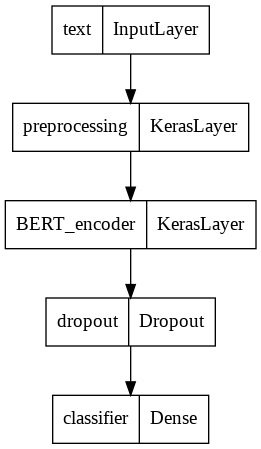

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
# definición de la funcion de perdida y la metrica a utilizar
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# parametrización
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compilación del modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
## entrenamiento del modelo con todas la noticias.
%%time
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/20
67/67 [==============================] - 89s 981ms/step - loss: 0.6961 - binary_accuracy: 0.4974 - val_loss: 0.6931 - val_binary_accuracy: 0.4953
Epoch 2/20
67/67 [==============================] - 67s 995ms/step - loss: 0.6932 - binary_accuracy: 0.5012 - val_loss: 0.6931 - val_binary_accuracy: 0.4953
Epoch 3/20
67/67 [==============================] - 67s 1s/step - loss: 0.7019 - binary_accuracy: 0.5474 - val_loss: 0.6603 - val_binary_accuracy: 0.5784
Epoch 4/20
67/67 [==============================] - 68s 1s/step - loss: 0.6257 - binary_accuracy: 0.7135 - val_loss: 0.6425 - val_binary_accuracy: 0.7732
Epoch 5/20
67/67 [==============================] - 68s 1s/step - loss: 0.6365 - binary_accuracy: 0.7286 - val_loss: 0.5714 - val_binary_accuracy: 0.7921
Epoch 6/20
67/67 [==============================] - 68s 1s/step - loss: 0.5335 - binary_accuracy: 0.8188 - val_loss: 0.6332 - val_binary_acc

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


21/21 [==============================] - 7s 338ms/step - loss: 1.2416 - binary_accuracy: 0.8278
Loss: 1.2416189908981323
Accuracy: 0.8277945518493652


In [ ]:
clasif_BERT=classifier_model.predict(test_ds)

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


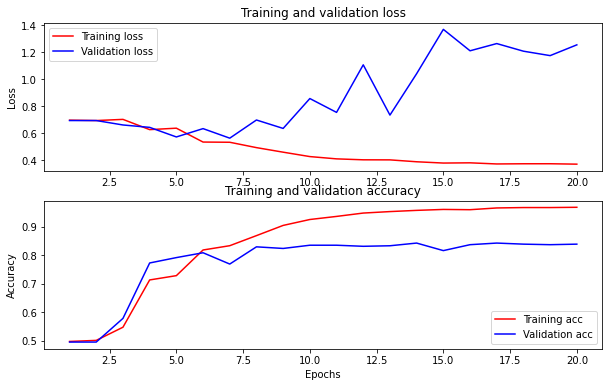

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'noticias'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)


INFO:tensorflow:Assets written to: ./noticias_bert/assets


INFO:tensorflow:Assets written to: ./noticias_bert/assets


In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def pruebas(df,results):
  df_noticias=[]
  for i in tqdm(range(len(df))):
    if(results[i][0]>0.5):
      df_noticias.append(True)
    else:
      df_noticias.append(False)
  return df_noticias
  
def pruebasPrediccion(inputs, results):
    return results[i][0]

def classification_news_(df):
  df_noticias=[]
  for noticia in tqdm(df):
    df_noticias.append(detection_fake_news_(noticia))
  return df_noticias

In [ ]:
df_testNoticiasMejicanas

,CATEGORY,TEXT
0,True,El control de la Covid-19 no es sólo un tema d...
1,False,El Gobierno de Pedro Sánchez y Pablo Iglesias ...
2,True,Las tres federaciones que agrupan al 90% de la...
3,False,Se han dado a conocer los datos electorales pr...
4,True,La primera fase del censo será virtual y solo ...
...,...,...
567,True,El Instituto de Diagnóstico y Referencia Epide...
568,False,La hija del rey Felipe y de la reina Letizia y...
569,False,"Evidentemente, Barak Obama ha sido arrestado e..."
570,True,El Ministerio de Sanidad ha actualizado los da...


In [ ]:
testNotciasColombianas=pd.read_excel("fakeNewsColombia.xlsx")

In [ ]:
testNotciasColombianas.head()

,Etiqueta,Texto
0,False,Posibles narcotraficantes están financiando ca...
1,False,"En una entrevista reciente, se le preguntó al..."
2,False,En una iglesia ucraniana que quedó totalmente ...
3,False,"las palomas tienen más proteínas, en Suecia co..."
4,False,"Q tristeza q tengan q pagar gente inocente, y..."


In [ ]:
reloaded_results = tf.sigmoid(reloaded_model(tf.constant(testNotciasColombianas['Texto'])))
print('Results from the saved model:')
df_result_BERT=pruebas(testNotciasColombianas['Texto'], reloaded_results)

Results from the saved model:


100%|██████████| 32/32 [00:00<00:00, 89.78it/s]


In [ ]:
real_label=testNotciasColombianas['Etiqueta']

In [ ]:
print(type(df_result_BERT))
print(type(real_label))

<class 'list'>
<class 'pandas.core.series.Series'>


Text(39.49999999999999, 0.5, 'Predicted')

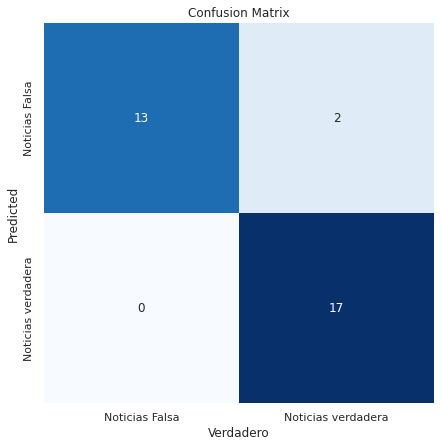

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(real_label, df_result_BERT)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

,Noticias Falsa,Noticias verdadera
Noticias Falsa,13,2
Noticias verdadera,0,17


In [ ]:
print(classification_report(real_label,df_result_BERT, target_names=['Noticia verdadera','Noticia Falsa']))

                   precision    recall  f1-score   support

Noticia verdadera       1.00      0.87      0.93        15
    Noticia Falsa       0.89      1.00      0.94        17

         accuracy                           0.94        32
        macro avg       0.95      0.93      0.94        32
     weighted avg       0.94      0.94      0.94        32



In [ ]:
archivo_zip = shutil.make_archive("modelo", 
                                  "zip", 
                                  base_dir ="noticias_bert")

In [ ]:
archivo_zip = shutil.make_archive("modeloFakeNewsDetecColombia", 
                                  "zip", 
                                  base_dir ="noticiasColombianas_bert")

#**Evaluación**

###**Evaluación de Modelos con Corpus Propio**

In [ ]:
listas_cp=[["Random Forest",accuracy_randomforest_cp],["Naive Bayes",accuracy_nb_cp],["SVC",accuracy_svc_cp],["Logistic Regression",accuracy_logistic_cp],["XGBoost",accuracy_xgb_cp],
           ["Neural Network",accuracy_nn_cp]]
df_listas_cp=pd.DataFrame(listas_cp,columns=["Modelos","Métrica - Accuracy"])
df_listas_cp
df_listas_cp.style.set_properties(**{'border': '1.3px solid black','text-align': 'center',
                          'color': '#000000'})

,Modelos,Métrica - Accuracy
0,Random Forest,0.897638
1,Naive Bayes,0.874016
2,SVC,0.889764
3,Logistic Regression,0.897638
4,XGBoost,0.881890
5,Neural Network,0.684310


###**Evaluación de Modelos con el Corpus Mejorado**

In [ ]:
listas=[["Random Forest",accuracy_randomforest],["Naive Bayes",accuracy_nb],["SVC",accuracy_svc],["Logistic Regression",accuracy_logistic],["XGBoost",accuracy_xgb],
         ["Neural Network",accuracy_nn]]
df_listas=pd.DataFrame(listas,columns=["Modelos","Métrica - Accuracy"])
df_listas
df_listas.style.set_properties(**{'border': '1.3px solid black','text-align': 'center',
                          'color': '#FFFFFF'})

,Modelos,Métrica - Accuracy
0,Random Forest,0.697885
1,Naive Bayes,0.625378
2,SVC,0.693353
3,Logistic Regression,0.678248
4,XGBoost,0.711480
5,Neural Network,0.691843


# **Pruebas**

In [ ]:
def detection_fake_news_cp(news):
    news=text_preprocessing(news)
    input_data = [news]
    vectorized_input_data = tfidf_cp.transform(input_data)
    prediction = clf_cp.predict(vectorized_input_data)
    prediction_proba = clf_cp.predict_proba(vectorized_input_data)
    if prediction==0:
      return True
    else:
      return False

In [ ]:
def detection_fake_news_(news):
    news=text_preprocessing(news)
    input_data = [news]
    vectorized_input_data = tfidf.transform(input_data)
    prediction = clf.predict(vectorized_input_data)
    prediction_proba = clf.predict_proba(vectorized_input_data)
    if prediction==0:
      return True
    else:
      return False


In [ ]:
real_label=testNotciasColombianas['Etiqueta']

In [ ]:
def classification_news_twitter(accountname_twitter,count_tweets):
  df_temp_tweets=get_tweets(api,accountname_twitter,count_tweets,False)
  for tweet in df_temp_tweets:
    df_news_classified.append(detection_fake_news_(tweet))
  return df_news_classified
  

In [ ]:
def classification_news_cp(df):
  df_noticias_cp=[]
  for noticia in tqdm(df):
    df_noticias_cp.append(detection_fake_news_cp(noticia))
  return df_noticias_cp

In [ ]:
def classification_news_(df):
  df_noticias=[]
  for noticia in tqdm(df):
    df_noticias.append(detection_fake_news_(noticia))
  return df_noticias

In [ ]:
df_clasificacion_cp=classification_news_cp(testNotciasColombianas['Texto'])

100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


In [ ]:
df_clasificacion=classification_news_(testNotciasColombianas['Texto'])

100%|██████████| 32/32 [00:06<00:00,  4.86it/s]


In [ ]:
val_label=testNotciasColombianas['Etiqueta']

Text(39.49999999999999, 0.5, 'Predicted')

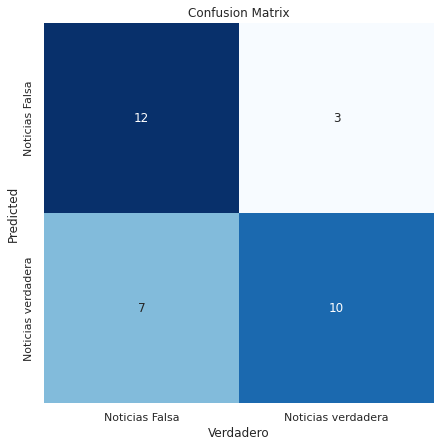

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(val_label, df_clasificacion_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

,Noticias Falsa,Noticias verdadera
Noticias Falsa,12,3
Noticias verdadera,7,10


In [ ]:
print(classification_report(val_label,df_clasificacion_cp, target_names=['Noticia verdadera','Noticia Falsa']))

                   precision    recall  f1-score   support

Noticia verdadera       0.63      0.80      0.71        15
    Noticia Falsa       0.77      0.59      0.67        17

         accuracy                           0.69        32
        macro avg       0.70      0.69      0.69        32
     weighted avg       0.70      0.69      0.69        32



Text(39.49999999999999, 0.5, 'Predicted')

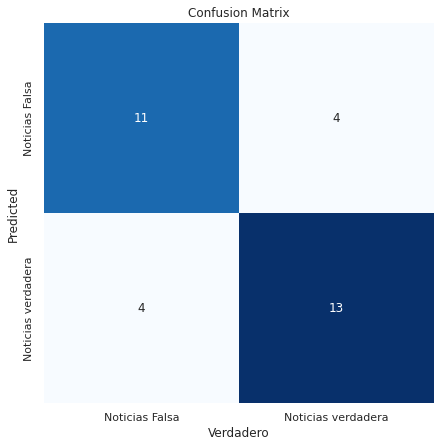

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(val_label, df_clasificacion)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

,Noticias Falsa,Noticias verdadera
Noticias Falsa,11,4
Noticias verdadera,4,13


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(val_label,df_clasificacion, target_names=['Noticia verdadera','Noticia Falsa']))

                   precision    recall  f1-score   support

Noticia verdadera       0.73      0.73      0.73        15
    Noticia Falsa       0.76      0.76      0.76        17

         accuracy                           0.75        32
        macro avg       0.75      0.75      0.75        32
     weighted avg       0.75      0.75      0.75        32



In [ ]:
classification_news_twitter("juanmontan0",2)

# **Modelos para producción**

### Se guardan los modelos para su paso a producción

# Nueva sección

In [ ]:
#create_model_production("RF",clf)
create_model_production("NB",best_model_nb)
create_model_production("SVC",best_model_svc)
create_model_production("LR",best_model_logistic)
create_model_production("Xgboost",best_model_xgb)
create_model_production("vectorizer",tfidf)
create_model_production("vectorizer_cp",tfidf_cp)